In [1]:
import os
import sys
sys.path.append('/fefs/aswg/workspace/mitsunari.takahashi/Soft/common')

from LowLevelAnalysis import ConfigItem, ImageExtractorConfig, TailcutConfig, LowLevelAnalysis
from LowLevelData import Data, DL0Data, DL0DataSingleFile, DL1Data, DL1DataSingleFile

import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import math

from math import ceil
import numpy as np
import numpy.ma as ma
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import tables
from collections import OrderedDict

import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack
import datetime

from traitlets.config.loader import Config
from ctapipe_io_lst import LSTEventSource
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import hillas_parameters
from ctapipe.containers import EventType

from lstchain.io.config import read_configuration_file
import lstchain.reco.utils as utils
from lstchain.reco import r0_to_dl1
from lstchain.io.io import dl1_images_lstcam_key, dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_lstcam_key, dl1_params_src_dep_lstcam_key

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.io.eventseeker import EventSeeker
#import astropy.units as u
#from copy import deepcopy

from scipy.stats import binned_statistic

import pSLUM

In [2]:
from logging import getLogger,StreamHandler,DEBUG,INFO,WARNING,ERROR,CRITICAL

##### Logger #####
logger = getLogger(__name__)
handler = StreamHandler()
loglevel = 'INFO'
handler.setLevel(loglevel)
logger.setLevel(loglevel)
logger.addHandler(handler)

In [3]:
from lstchain import __version__ as lstchain_version
logger.info(lstchain_version)
#lstchain_version = lstchain_version.rsplit('.',maxsplit=1)[0]
#logger.info(lstchain_version)

0.8.5.dev6+g50b0a41.d20220127


In [4]:
# Matplotlib setup
plt.rcParams["font.size"] = 13

LINE_STYLES = ["solid", "dashed", "dashdot", "dotted"]
MARKER_STYLES = ['o', 's', 'x', '+', 'D', 'X', 'p', 'd', '<', '>', '^', 'v', 'H']

#plt.xkcd()

In [5]:
# Replace OUTPUT_DIR_PATH by your directory
OUTPUT_DIR_PATH = Path('/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses')
if not OUTPUT_DIR_PATH.exists():
    os.makedirs(OUTPUT_DIR_PATH)


# Config of Tailcut

In [6]:
tailcut_configs = [TailcutConfig({"picture_thresh":8, "boundary_thresh":4, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth8_bth4'),
                   TailcutConfig({"picture_thresh":6, "boundary_thresh":3, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth6_bth3'),
                   TailcutConfig({"picture_thresh":5, "boundary_thresh":3, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth5_bth3'),
                  TailcutConfig({"picture_thresh":5, "boundary_thresh":2, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth5_bth2')]

# Config of ImageExtracter

## List of confugurations to evaluate  

In [7]:
image_extractor_configs = []
real_image_extractor_configs = []

# NeighborPeakWindowSum
for window_width in (3,4,5,8):
    window_shift = int(window_width/2)
    image_extractor_configs.append(ImageExtractorConfig('NeighborPeakWindowSum', 
                                                        {'window_shift':window_shift,
                                                         'window_width':window_width,
                                                         'apply_integration_correction':'true'}
                                                       , abbreviation='NPWS_w{w}'.format(w=window_width)))
    real_image_extractor_configs.append(ImageExtractorConfig('NeighborPeakWindowSum', 
                                                        {'window_shift':window_shift,
                                                         'window_width':window_width,
                                                         'apply_integration_correction':'false'}
                                                       , abbreviation='NPWS_w{w}'.format(w=window_width)))

In [8]:
# Write the config files down     
lowlevel_configs= []
real_lowlevel_configs= []
for tailcut_config in tailcut_configs:
    for ie in image_extractor_configs:
        lowlevel_configs.append(LowLevelAnalysis(configs=[ie, tailcut_config], 
                                             output_dir_path=OUTPUT_DIR_PATH, 
                                             config_dir_path=OUTPUT_DIR_PATH,
                                            abbreviation='_'.join([ie.abbreviation, tailcut_config.abbreviation])))
        real_lowlevel_configs.append(LowLevelAnalysis(configs=[ie, tailcut_config], 
                                             output_dir_path=OUTPUT_DIR_PATH, 
                                             config_dir_path=OUTPUT_DIR_PATH,
                                            abbreviation='_'.join([ie.abbreviation, tailcut_config.abbreviation])))
for c in lowlevel_configs:    
    c.write_configfile()
for c in real_lowlevel_configs:    
    c.write_configfile()    

# Shower event selection

In [9]:
EMIN = 0 *u.GeV
EMAX = 100 *u.GeV

In [10]:
tel_id = 1 #LST-1
allowed_tels = {tel_id}

In [11]:
REQUSTED_PARAMETERS = ["event_type",
                       'intensity', 
                       'log_intensity', 
                       'length', 
                       'width', 
                       'wl', 
                       'skewness',
                       'kurtosis', 
                       'leakage_intensity_width_2', 
                       'n_islands',
                       'intercept',
                       'n_pixels',
                       'time_gradient',
                       'concentration_cog', 
                       'concentration_core',
                       'concentration_pixel']

In [12]:
HILLASES_OF_INTEREST = ['intensity', 
                        'log_intensity', 
                        'length', 
                        'width', 
                        'wl', 
                        'skewness',
                        'kurtosis', 
                        'leakage_intensity_width_2', 
                        'n_islands',
                        'n_pixels',
                        'time_gradient',
                        'concentration_cog', 
                        'concentration_core',
                        'concentration_pixel']

# Real data

In [13]:
real_runs = [3948, 4699, 4859, 2969, 3094, 3954] #4066] #2181, 4859]
real_dates = {3948: '20210310', 4699: '20210511', 2181: '20200710', 4859: '20210531',
              2969: '20201120', 3094: '20201207', 4066: '20210315', 3954: '20210311'}
real_subruns = {3948: range(50, 51), 4699: range(50, 51), 2181: range(50, 51), 4859: range(50, 51), 
                2969: range(50, 51), 3094: range(50, 51), 4066: range(50, 51), 3954: range(50, 51)}
calibration_runs = {3948:3945, 4699: 4696, 2181: 2175, 4859: 4851, 
                    2969: 2964, 3094: 3092, 4066: 4076, 3954: 3963}
drs4_pedestal_runs = {3948: 3944, 4699: 4695, 2181: 2174, 4859: 4850, 
                      2969: 2963, 3094: 3091, 4066: 4065, 3954:3958}
#time_calibration_runs = {3948: 3945, 4699: 4696, 2181: 2175, 4859: 4851}
time_calibration_runs = {3948: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         4699: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20210321/v0.8.0/time_calibration.Run04211.0000.h5',
                         2181: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         4859: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20210321/v0.8.0/time_calibration.Run04211.0000.h5',
                         2969: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         3094: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',                         
                         4066: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         3954: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',                         
                         }
#enf_sys_dates = {3948: '20210321', 4699: '20210403', 2181: '20200725', 4859: '20210514'}
#analysis_version = {3948: 'v0.7.1', 4699: 'v0.7.3', 2181: 'v0.7.3', 4859: 'v0.7.3',
#                    2969: 'v0.8.3', 3094: 'v0.8.3', 4066: 'v0.7.1'}
source_runs = {3948: 'DP', 4699: 'DP', 2181: 'DP', 4859: 'DP',
               2969: 'Crab', 3094: 'Crab', 4066: 'Crab', 3954: 'Crab'}
zenith_runs = {3948: 'Low', 4699: 'Low', 2181: 'Low', 4859: 'Low',
                  2969: 'Low', 3094: 'Low', 4066: 'Low', 3954: 'Low'}

# Real DL1 data

## DRS4 baseline

In [14]:
FILTER_COMBINATION = '52'

In [15]:
real_dl1_data_dict = {}

real_r0_paths = {}
calibration_paths = {}
drs4_pedestal_paths = {}
time_calibration_paths = {}
drive_log_paths = {}
run_summary_path = {}
        
for run in real_runs:

    # Time calibration file (Ocasional)
    #time_calibration_paths[run] = Path('/fefs/aswg/data/real/calibration/{date}/{ver}/time_calibration.Run{run:0>5.0f}.0000.hdf5'\
                                      #.format(date=real_dates[run], ver=analysis_version[run], run=time_calibration_runs[run]))
    time_calibration_paths[run] = Path(time_calibration_runs[run])
    if not time_calibration_paths[run].is_file():
        logger.error('{0} does NOT exist!!'.format(time_calibration_paths[run]))
        break  
    
    # Drive file
    drive_log_paths[run] = Path('/fefs/aswg/data/real/monitoring/DrivePositioning/drive_log_{yr}_{mon}_{day}.txt'\
                                .format(yr=real_dates[run][2:4], mon=real_dates[run][4:6], day=real_dates[run][6:8]))
    if not drive_log_paths[run].is_file():
        logger.error('{0} does NOT exist!!'.format(drive_log_paths[run]))
        break   
    # Run summary (Reference Dragon counter)
    run_summary_path[run] = Path('/fefs/aswg/data/real/monitoring/RunSummary/RunSummary_{date}.ecsv'.format(date=real_dates[run]))
    if not run_summary_path[run].is_file():
        logger.error('{0} does NOT exist!!'.format(run_summary_path[run]))    

#for lowlevel_config in real_lowlevel_configs:
    # Prepare directories
out_dir_path = OUTPUT_DIR_PATH / 'real' #/ 'DL1' #lowlevel_config.product_dir_path / 'real' / 'DL1'
if not out_dir_path.is_dir():
    out_dir_path.mkdir(parents=True) 
        
    # Process data  
    #real_dl1_data_dict[lowlevel_config] = {}
for run in real_runs:
        # DRS4 pedestal (baseline)
        ## Directory
    drs4ped_dir_path = out_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'drs4_baseline'
        #drs4ped_dir_path = lowlevel_config.product_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'drs4_baseline'
        #/drs4_baseline/{date}/{prod_id} #'real' / 'drs4_baseline'
    drs4_pedestal_paths[run] = out_dir_path / 'monitoring/PixelCalibration/LevelA/drs4_baseline/{date}/v{ver}/drs4_pedestal.Run{run:0>5.0f}.0000.h5'\
    .format(date=real_dates[run], ver=lstchain_version, run=drs4_pedestal_runs[run])
    if not drs4_pedestal_paths[run].is_file():
        if not drs4ped_dir_path.is_dir():
            drs4ped_dir_path.mkdir(parents=True)  

        ## File    
        #drs4_pedestal_paths[run] = Path('{di}/drs4_pedestal.Run{run:0>5.0f}.0000.h5'\
        #                              .format(di=drs4ped_dir_path, run=drs4_pedestal_runs[run]))
        #if not drs4_pedestal_paths[run].is_file():
        # DRS4 baseline file creation
        command = ['python', 
               '/home/mitsunari.takahashi/Work/Soft/cta-lstchain/lstchain/scripts/onsite/onsite_create_drs4_pedestal_file.py', 
                   '--run_number', str(drs4_pedestal_runs[run]),
                   '--base_dir', str(out_dir_path), #str(lowlevel_config.product_dir_path),
                   '--no-progress']
                   #'--input', '/fefs/aswg/data/real/R0/{date}/LST-{tel}.1.Run{run:0>5.0f}.0000.fits.fz'.format(date=real_dates[run], tel=tel_id, run=drs4_pedestal_runs[run]), 
                   #'--output', str(drs4_pedestal_paths[run]),
                   #'--config', str(lowlevel_config.config_path)]#, 
                   #'--overwrite']
        timesubmit = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        job = pSLUM.Job(' '.join(command), 
                        options={'partition': 'short', 
                                 'job-name': 'ped{run}'.format(run=run), 
                                 #'job-name': 'ped{run}{ana}'.format(ana=lowlevel_config.name, run=run), 
                                 'nodes': 1, 
                                 'exclusive': False, 
                                 'output': drs4ped_dir_path / 'output' / 'onsite_create_drs4_pedestal_file_run{0:0>5.0f}_{1}.out'.format(run, timesubmit), 
                                 'error': drs4ped_dir_path / 'error' / 'onsite_create_drs4_pedestal_file_run{0:0>5.0f}_{1}.err'.format(run, timesubmit)}
                        )
        slum_script_path = drs4ped_dir_path / 'script' / 'onsite_create_drs4_pedestal_file_{run}.sh'.format(run=run)
        job.write_script(slum_script_path)
        job.run()
    #logger.info(' '.join(command))
    #subprocess.run(command)   
    #break

            


In [16]:
!squeue -u mitsunari.takahashi

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
          14269885     short 3954.50L mitsunar  R       0:15      1 cp22 
          14269886     short 3954.50L mitsunar  R       0:15      1 cp03 
          14269887     short 3954.50L mitsunar  R       0:15      1 cp24 
          14269888     short 3954.50L mitsunar  R       0:15      1 cp24 
          14269889     short 3954.50L mitsunar  R       0:15      1 cp39 
          14269890     short 3954.50L mitsunar  R       0:15      1 cp39 
          14269891     short 3954.50L mitsunar  R       0:15      1 cp39 
          14269892     short 3954.50L mitsunar  R       0:15      1 cp06 
          14269893     short 3954.50L mitsunar  R       0:15      1 cp06 


In [17]:
for run in real_runs:
        # Calibration file
        ## Directory
    calib_dir_path = out_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'calibration'
        #calib_dir_path = lowlevel_config.product_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'calibration'
    calibration_paths[run] = out_dir_path / 'monitoring/PixelCalibration/LevelA/calibration/{date}/v{ver}/calibration_filters_{filters}.Run{run:0>5.0f}.0000.h5'\
    .format(date=real_dates[run], ver=lstchain_version, filters=FILTER_COMBINATION, run=calibration_runs[run])
    
    if not calibration_paths[run].is_file():
        if not calib_dir_path.is_dir():
            calib_dir_path.mkdir(parents=True)  
        ## File       
        #calibration_paths[run] = Path('{di}}/calibration.Run{run:0>5.0f}.0000.hdf5'\
        #                            .format(di=calib_dir_path, run=calibration_runs[run]))
        #if not calibration_paths[run].is_file():
            # PMT calibration file creation            
        command = ['python', 
                       '/home/mitsunari.takahashi/Work/Soft/cta-lstchain/lstchain/scripts/onsite/onsite_create_calibration_file.py', 
                       '--run_number', str(calibration_runs[run]), 
                       '--pedestal_run', str(drs4_pedestal_runs[run]),
                       '--base_dir', str(out_dir_path), #str(lowlevel_config.product_dir_path),
                       #'--time_run', str(time_calibration_runs[run]), 
                       #'--sys_date', str(enf_sys_dates[run]),
                       '--filters', FILTER_COMBINATION]
                       #'--input', '/fefs/aswg/data/real/R0/{date}/LST-{tel}.1.Run{run:0>5.0f}.0000.fits.fz'.format(date=real_dates[run], tel=tel_id, run=calibration_runs[run]), 
                       #'--output', str(calibration_paths[run]),
                       #'--config', str(lowlevel_config.config_path)]#, 
                       #'--overwrite']
        timesubmit = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        job = pSLUM.Job(' '.join(command), 
                            options={'partition': 'short', 
                                     'job-name': 'cal{run}'.format(run=run), 
                                     #'job-name': 'cal{run}{ana}'.format(ana=lowlevel_config.name, run=run), 
                                     'nodes': 1, 
                                     'exclusive': False, 
                                     'output': calib_dir_path / 'output' / 'onsite_create_calibration_file_run{0:0>5.0f}_{1}.out'.format(run, timesubmit), 
                                     'error': calib_dir_path / 'error' / 'onsite_create_calibration_file_run{0:0>5.0f}_{1}.err'.format(run, timesubmit)}
                           )
        slum_script_path = calib_dir_path / 'script' / 'onsite_create_calibration_file_{run}.sh'.format(run=run)
        job.write_script(slum_script_path)
        job.run()   
    #logger.info(' '.join(command))
    #subprocess.run(command) 



In [18]:
!squeue -u mitsunari.takahashi

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
          14269885     short 3954.50L mitsunar  R       0:17      1 cp22 
          14269886     short 3954.50L mitsunar  R       0:17      1 cp03 
          14269887     short 3954.50L mitsunar  R       0:17      1 cp24 
          14269888     short 3954.50L mitsunar  R       0:17      1 cp24 
          14269889     short 3954.50L mitsunar  R       0:17      1 cp39 
          14269890     short 3954.50L mitsunar  R       0:17      1 cp39 
          14269891     short 3954.50L mitsunar  R       0:17      1 cp39 
          14269892     short 3954.50L mitsunar  R       0:17      1 cp06 
          14269893     short 3954.50L mitsunar  R       0:17      1 cp06 


In [19]:
for run in real_runs:
    for calfile in (drs4_pedestal_paths[run], calibration_paths[run]):
        if not calfile.is_file():
            logger.error('{0} has NOT been created!!'.format(calfile))   
        else:
            calfile_size = os.path.getsize(calfile)
            logger.info('Size of {0}: {1:.2f} MB'.format(calfile, calfile_size/1024**2))

Size of /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/drs4_baseline/20210310/v0.8.5.dev6+g50b0a41.d20220127/drs4_pedestal.Run03944.0000.h5: 17.08 MB
Size of /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/calibration/20210310/v0.8.5.dev6+g50b0a41.d20220127/calibration_filters_52.Run03945.0000.h5: 0.41 MB
Size of /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/drs4_baseline/20210511/v0.8.5.dev6+g50b0a41.d20220127/drs4_pedestal.Run04695.0000.h5: 17.15 MB
Size of /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/calibration/20210511/v0.8.5.dev6+g50b0a41.d20220127/calibration_filters_52.Run04696.0000.h5: 0.41 MB
Size of /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/drs4_baseline/20210531/v0.8.5.dev

In [20]:
script_path_str='/home/mitsunari.takahashi/Work/Soft/cta-lstchain/lstchain/scripts/lstchain_data_r0_to_dl1.py'
subrun_dl1_paths = {}

for lowlevel_config in real_lowlevel_configs:
    subrun_dl1_paths[lowlevel_config] = {}
    # Prepare directories
    out_dir_path = lowlevel_config.product_dir_path / 'real' / 'DL1'
    if not out_dir_path.is_dir():
        out_dir_path.mkdir(parents=True) 
        
    # Process data  
    #real_dl1_data_dict[lowlevel_config] = {}
    for run in real_runs:
        #real_dl1_data_dict[lowlevel_config][run] = DL1Data(name='DL1 Real Run {0}'.format(run), datasrc='Real', 
        #                                          hillas_parameters=HILLASES_OF_INTEREST, 
        #                                          emin=EMIN, emax=EMAX, tel_id=tel_id)
        # R0 data file
        real_r0_paths[run] = []
        #subrun_data_list = []
        subrun_dl1_paths[lowlevel_config][run] = {}
        for subrun in real_subruns[run]:
            real_r0_paths[run].append(Path('/fefs/aswg/data/real/R0/{date}/LST-1.1.Run{run:0>5.0f}.{subrun:0>4.0f}.fits.fz'\
                                      .format(date=real_dates[run],run=run, subrun=subrun)))
            if not real_r0_paths[run][-1].is_file():
                logger.error('{0} does NOT exist!!'.format(real_r0_paths[run][-1]))
                break    
                
            # R0 to DL1
            subrun_dl1_path = out_dir_path / 'dl1_LST-{tel}.Run{run:0>5.0f}.{subrun:0>4.0f}.h5'.format(tel=tel_id ,run=run, subrun=subrun)
            subrun_dl1_paths[lowlevel_config][run][subrun] = subrun_dl1_path
            # Check
            #%rm $subrun_dl1_path # Delete old file
            if subrun_dl1_path.is_file(): 
                logger.warning('{0} already exists!'.format(subrun_dl1_path))
                #continue
            else:    
                if not subrun_dl1_path.is_file():         
                    command = ['python', script_path_str,
                               '--input-file', '{r0_path}'.format(r0_path=real_r0_paths[run][-1]), 
                               '--config', '{config_path}'.format(config_path=lowlevel_config.config_path), 
                               '--output-dir', '{product_dir_path}'.format(product_dir_path=out_dir_path),
                               '--pedestal-file', '{drs4_pedestal_path}'.format(drs4_pedestal_path=drs4_pedestal_paths[run]),
                               '--calibration-file', '{calibration_path}'.format(calibration_path=calibration_paths[run]),
                               '--time-calibration-file', '{time_calibration_path}'.format(time_calibration_path=time_calibration_paths[run]),
                               '--pointing-file', '{pointing_path}'.format(pointing_path=drive_log_paths[run]), 
                               '--run-summary-path', '{runsummary}'.format(runsummary=run_summary_path[run]), 
                               #'--dragon-reference-time', '{}'.format(1620774291960678001)
                              ]
                    #logger.info(' '.join(command))
                    #dl1_production_result = subprocess.run(['srun']+command)
                    
                    timesubmit = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                    job = pSLUM.Job(' '.join(command),
                                    options={'partition': 'short', 
                                             'job-name': '{run}.{subrun}{ana}'.format(ana=lowlevel_config.name, run=run, subrun=subrun), 
                                             'nodes': 1, 
                                             'exclusive': False, 
                                             'output': out_dir_path / 'output' / 'lstchain_data_r0_to_dl1_run{0:0>5.0f}_subrun{1:0>4.0f}_{2}.out'.format(run, subrun, timesubmit), 
                                             'error': out_dir_path / 'error' / 'lstchain_data_r0_to_dl1_run{0:0>5.0f}_subrun{1:0>4.0f}_{2}.err'.format(run, subrun, timesubmit)}
                                   )
                    slum_script_path = out_dir_path / 'script' / 'lstchain_data_r0_to_dl1_run{0:0>5.0f}_subrun{1:0>4.0f}_{2}.sh'.format(run, subrun, timesubmit)
                    job.write_script(slum_script_path)
                    job.run()                    
                    
            #    if not subrun_dl1_path.is_file(): 
            #        logger.error('{0} has NOT been produced!!'.format(subrun_dl1_path))
            #subrun_data_list.append(DL1DataSingleFile(name='DL1 Real Run {0} Subrun {1}'.format(run, subrun), 
            #                                          file_path=subrun_dl1_path, datasrc='Real', used_event_ids=None, 
            #                                          true_phe=None, true_log10_phe=None, 
            #                                          hillas_parameters=HILLASES_OF_INTEREST, 
            #                                          emin=EMIN, emax=EMAX, tel_id=tel_id))
        #real_dl1_data_dict[lowlevel_config][run].add_data(datum_list=subrun_data_list)                                                           

Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03948_subrun0050_20220127-075406.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04699_subrun0050_20220127-075406.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_p

Submitted batch job 14269894
Submitted batch job 14269895
Submitted batch job 14269896


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03954_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_p

Submitted batch job 14269897
Submitted batch job 14269898
Submitted batch job 14269899
Submitted batch job 14269900
Submitted batch job 14269901


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_p

Submitted batch job 14269902
Submitted batch job 14269903
Submitted batch job 14269904
Submitted batch job 14269905
Submitted batch job 14269906
Submitted batch job 14269907


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_p

Submitted batch job 14269908
Submitted batch job 14269909
Submitted batch job 14269910
Submitted batch job 14269911
Submitted batch job 14269912
Submitted batch job 14269913


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075407.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_p

Submitted batch job 14269914
Submitted batch job 14269915
Submitted batch job 14269916
Submitted batch job 14269917
Submitted batch job 14269918
Submitted batch job 14269919


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269920
Submitted batch job 14269921
Submitted batch job 14269922
Submitted batch job 14269923
Submitted batch job 14269924


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269925
Submitted batch job 14269926
Submitted batch job 14269927
Submitted batch job 14269928
Submitted batch job 14269929
Submitted batch job 14269930


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269931
Submitted batch job 14269932
Submitted batch job 14269933
Submitted batch job 14269934
Submitted batch job 14269935
Submitted batch job 14269936
Submitted batch job 14269937


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075408.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269938
Submitted batch job 14269939
Submitted batch job 14269940
Submitted batch job 14269941
Submitted batch job 14269942
Submitted batch job 14269943


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269944
Submitted batch job 14269945
Submitted batch job 14269946
Submitted batch job 14269947
Submitted batch job 14269948
Submitted batch job 14269949


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269950
Submitted batch job 14269951
Submitted batch job 14269952
Submitted batch job 14269953
Submitted batch job 14269954
Submitted batch job 14269955


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269956
Submitted batch job 14269957
Submitted batch job 14269958
Submitted batch job 14269959
Submitted batch job 14269960
Submitted batch job 14269961


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_p

Submitted batch job 14269962
Submitted batch job 14269963
Submitted batch job 14269964
Submitted batch job 14269965
Submitted batch job 14269966
Submitted batch job 14269967


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075409.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_p

Submitted batch job 14269968
Submitted batch job 14269969
Submitted batch job 14269970
Submitted batch job 14269971
Submitted batch job 14269972
Submitted batch job 14269973


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075410.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075410.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_p

Submitted batch job 14269974
Submitted batch job 14269975
Submitted batch job 14269976
Submitted batch job 14269977
Submitted batch job 14269978


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0050_20220127-075410.sh


Submitted batch job 14269979


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02969_subrun0050_20220127-075414.sh


Submitted batch job 14269980


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075414.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03954_subrun0050_20220127-075414.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_p

Submitted batch job 14269981
Submitted batch job 14269982
Submitted batch job 14269983
Submitted batch job 14269984
Submitted batch job 14269985
Submitted batch job 14269986


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03094_subrun0050_20220127-075414.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03954_subrun0050_20220127-075414.sh


Submitted batch job 14269987
Submitted batch job 14269988
Submitted batch job 14269989


In [21]:
!squeue -u mitsunari.takahashi

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 


In [22]:
#%cat /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0000_20220115-152631.sh

In [23]:
for lowlevel_config in real_lowlevel_configs:
    # Process data  
    real_dl1_data_dict[lowlevel_config] = {}
    for run in real_runs:
        subrun_data_list = []
        real_dl1_data_dict[lowlevel_config][run] = DL1Data(name='DL1 Real Run {0}'.format(run), datasrc='Real', 
                                                  hillas_parameters=REQUSTED_PARAMETERS, 
                                                  emin=EMIN, emax=EMAX, tel_id=tel_id)    

        for subrun in real_subruns[run]:
            subrun_dl1_path = subrun_dl1_paths[lowlevel_config][run][subrun]
            if subrun_dl1_path.is_file(): 
                logger.info('{0} exists.'.format(subrun_dl1_path))
                #continue
            else:             
                logger.error('{0} has NOT been produced!!'.format(subrun_dl1_path))
                break
            subrun_data_list.append(DL1DataSingleFile(name='DL1 Real Run {0} Subrun {1}'.format(run, subrun), 
                                                      file_path=subrun_dl1_path, datasrc='Real', used_event_ids=None, 
                                                      true_phe=None, true_log10_phe=None, 
                                                      hillas_parameters=REQUSTED_PARAMETERS, 
                                                      emin=EMIN, emax=EMAX, tel_id=tel_id))
        real_dl1_data_dict[lowlevel_config][run].add_data(datum_list=subrun_data_list)   
          

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03948.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f671f017970>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04699.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f678999fdc0>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_t

Adding [<LowLevelData.DL1DataSingleFile object at 0x7f6653568760>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run02969.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f6651a93d60>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03094.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f648249a5b0>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_widt

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03954.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f6617d53f70>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03948.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f66162fa190>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_t

Adding [<LowLevelData.DL1DataSingleFile object at 0x7f65e2e885b0>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04859.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f65de00da90>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run02969.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f65de00dbe0>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_widt

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03094.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f655f5f3610>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03954.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f655f5f3760>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_t

In [24]:
!date
%ls -lth $subrun_dl1_path

Thu Jan 27 09:07:34 UTC 2022
-rw-r--r-- 1 mitsunari.takahashi ctan-onsite-it 710M Jan 27 08:22 /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03954.0050.h5


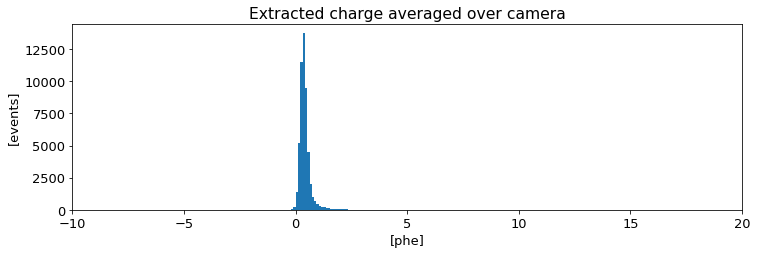

In [25]:
dl1_data = tables.open_file(subrun_dl1_path)
dl1_images = dl1_data.root.dl1.event.telescope.image.LST_LSTCam

images = [x['image'] for x in dl1_images.iterrows()]
timing = [x['peak_time'] for x in dl1_images.iterrows()]
image_averages = [np.average(y) for y in images]

rcParams['figure.figsize'] = 12, 7.5
plt.subplot(2, 1, 1)
h = plt.hist(image_averages, bins=1000)
plt.title('Extracted charge averaged over camera')
plt.xlabel('[phe]')
plt.ylabel('[events]')
plt.xlim(-10,20)
plt.show()

In [26]:
for j, lowlevel_config in enumerate(real_lowlevel_configs):
    logger.warning('===== {conf} ====='.format(conf=lowlevel_config.abbreviation))
    for k, run in enumerate(real_runs):
        #logger.warning('Run {run}'.format(run=run))
        dl1_data = real_dl1_data_dict[lowlevel_config][run]
        logger.warning('Data {dname}'.format(dname=dl1_data.name))        
        interleaved_pedestal = np.array(dl1_data.parameter_value_dict["event_type"])==EventType.SKY_PEDESTAL.value
        survived_pedestal = (np.array(dl1_data.parameter_value_dict["event_type"])==EventType.SKY_PEDESTAL.value) * (np.array(dl1_data.parameter_value_dict["intensity"])>0)
        #survived_flatfield = (np.array(dl1_data.parameter_value_dict["event_type"])==EventType.FLATFIELD.value) * (np.array(dl1_data.parameter_value_dict["intensity"])>0)
        logger.warning('    {n} pedestal events survived.'.format(n=sum(survived_pedestal))) 
        logger.info('    Survived fraction: {pf:3.3f}%'.format(pf=100*sum(survived_pedestal)/sum(interleaved_pedestal)))

===== NPWS_w3_pth8_bth4 =====
Data DL1 Real Run 3948
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 4699
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 4859
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 2969
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 3094
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 3954
    1 pedestal events survived.
    Survived fraction: 0.088%
===== NPWS_w4_pth8_bth4 =====
Data DL1 Real Run 3948
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 4699
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 4859
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 2969
    0 pedestal events survived.
    Survived fraction: 0.000%
Data DL1 Real Run 3094
    0 pedestal events survived.
    Survived fraction: 0.000%
Data 

    38 pedestal events survived.
    Survived fraction: 5.163%
Data DL1 Real Run 4699
    26 pedestal events survived.
    Survived fraction: 3.641%
Data DL1 Real Run 4859
    47 pedestal events survived.
    Survived fraction: 6.403%
Data DL1 Real Run 2969
    459 pedestal events survived.
    Survived fraction: 49.196%
Data DL1 Real Run 3094
    241 pedestal events survived.
    Survived fraction: 29.607%
Data DL1 Real Run 3954
    570 pedestal events survived.
    Survived fraction: 50.176%


/tmp/ipykernel_15969/1499573526.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


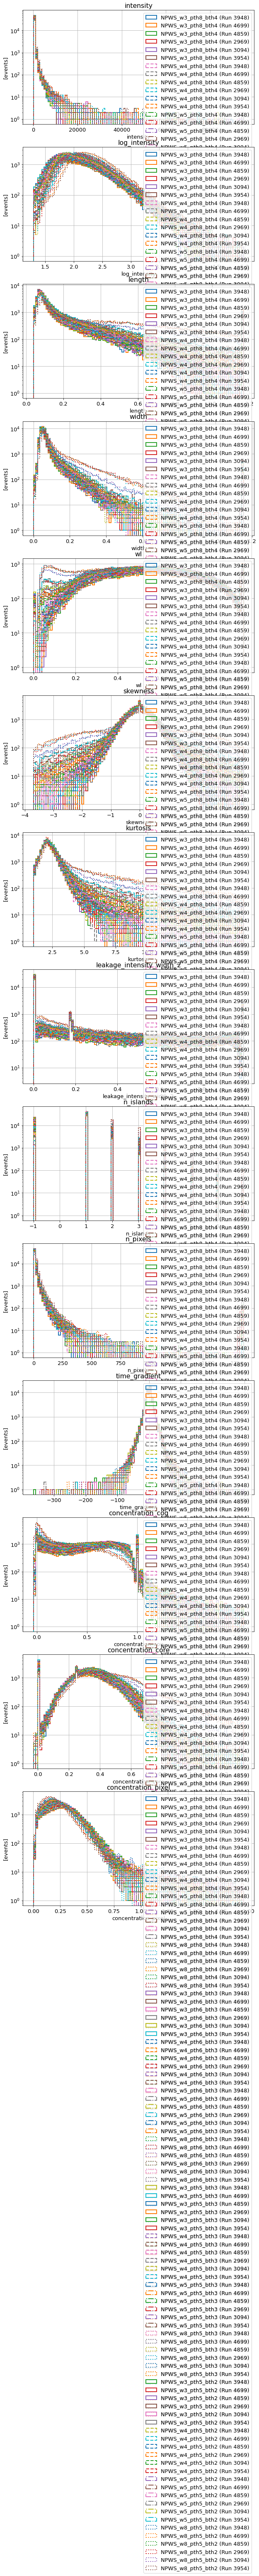

In [27]:
fig, axes = plt.subplots(len(HILLASES_OF_INTEREST), 1, figsize=(10, 6*len(HILLASES_OF_INTEREST)))
hist_results = {}

for i, param in enumerate(HILLASES_OF_INTEREST):
    for j, lowlevel_config in enumerate(real_lowlevel_configs):
        for k, run in enumerate(real_runs):
            dl1_data = real_dl1_data_dict[lowlevel_config][run]
            # Mask events
            event_masks = {}
            for mask_key in [EventType.FLATFIELD, EventType.SKY_PEDESTAL]:
                event_masks[mask_key] = np.array(dl1_data.parameter_value_dict["event_type"])==mask_key.value
            event_masks["intensity>100000"] = np.array(dl1_data.parameter_value_dict["intensity"])>100000
            event_masks["intensity<=0"] = np.array(dl1_data.parameter_value_dict["intensity"])<=0
            event_masks["width<=0"] = np.array(dl1_data.parameter_value_dict["width"])<=0            
            mask_sum = np.zeros_like(dl1_data.parameter_value_dict[param])
            for mask_array in event_masks.values():
                mask_sum += mask_array
            #mask_trigger = np.array(dl1_data.parameter_value_dict["intensity"])>20000
            
            vals = ma.masked_array(dl1_data.parameter_value_dict[param], mask=mask_sum)
            label = '{0} (Run {1})'.format(lowlevel_config.abbreviation, run)
            if not param in hist_results.keys():
                hist_results[param] = axes[i].hist(vals, lw=2, ls=LINE_STYLES[k], bins=100, histtype="step", label=label)
            else:
                axes[i].hist(vals, lw=2, ls=LINE_STYLES[j%len(LINE_STYLES)], bins=hist_results[param][1], histtype="step", label=label)
    axes[i].set_title(param)
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    #axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('[events]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

# MC DL0 data

In [28]:
N_MCEVENTS = 50

dl0_paths = []
for i in range(1, N_MCEVENTS+1):
    dl0_paths.append(Path('/fefs/aswg/data/mc/DL0/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/proton_20deg_180deg_run{r}___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.simtel.gz'.format(r=i)))

#dl0_path = Path('/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/4LSTs_MAGIC/gamma-diffuse/zenith_20deg/south_pointing/run1000/sim_telarray_v3_trans_80%/cta-prod5-lapalma_4LSTs_MAGIC/0.0deg/Data/gamma_20deg_180deg_run1000___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')
#dl0_path = Path('/fefs/aswg/data/mc/DL0/20200629_prod5/gamma-diffuse/zenith_20deg/south_pointing/gamma_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')

In [29]:
dl0_data = DL0Data(name='DL0 MC Proton', emin=EMIN, emax=EMAX, tel_id=tel_id)

In [30]:
dl0_datum_list = []
for idatum, dl0_path in enumerate(dl0_paths):
    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), 
                                            file_path=dl0_path, 
                                            emin=EMIN, emax=EMAX, 
                                            tel_id=tel_id))
dl0_data.add_data(datum_list=dl0_datum_list)

37 events has been added.
50 events has been added.
36 events has been added.
39 events has been added.
47 events has been added.
41 events has been added.
47 events has been added.
43 events has been added.
39 events has been added.
50 events has been added.
47 events has been added.
42 events has been added.
38 events has been added.
38 events has been added.
26 events has been added.
45 events has been added.
41 events has been added.
51 events has been added.
36 events has been added.
36 events has been added.
38 events has been added.
42 events has been added.
50 events has been added.
32 events has been added.
36 events has been added.
40 events has been added.
34 events has been added.
42 events has been added.
26 events has been added.
56 events has been added.
42 events has been added.
60 events has been added.
35 events has been added.
45 events has been added.
44 events has been added.
40 events has been added.
37 events has been added.
47 events has been added.
53 events ha


# MC DL1 data

In [31]:
dl1_data_dict = {}
for lowlevel_config in lowlevel_configs:
    logger.info(lowlevel_config.name)
    dl1_datum_list = []
    for dl0_datum in dl0_datum_list:
        dl1_datum_list.append(dl0_datum.produce_mc_dl1(lowlevel_config=lowlevel_config, 
                                                       hillas_parameters=REQUSTED_PARAMETERS))
        #print(dl1_datum_list[-1].true_phe)
        #print(len(dl1_datum_list[-1].dl1_image_tables))
        #print(dl1_datum_list[-1].file_path)
    dl1_data_dict[lowlevel_config] = DL1Data(name=dl0_data.name.replace('DL0','DL1').replace('dl0','dl1'),
                                             datasrc=dl0_data.DATASRC,
                                             hillas_parameters=REQUSTED_PARAMETERS,
                                             emin=EMIN, emax=EMAX, tel_id=tel_id)
    dl1_data_dict[lowlevel_config].add_data(datum_list=dl1_datum_list)
    if dl0_data.true_phe.size!=dl1_data_dict[lowlevel_config].dl1_reco_phe.size:
        logger.critical('The pulse number of DL0 ({0}) and that of DL1 ({1}) does not match!!!'\
                        .format(dl0_data.true_phe.size, dl1_data_dict[lowlevel_config].dl1_reco_phe.size))

NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 18 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 5 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 51 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 50 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 27 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 26 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 13 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 12 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 9 hours 43 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 8 hours 24 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 8 hours 23 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 8 hours 3 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 8 hours 2 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 7 hours 49 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 6 hours 28 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 6 hours 27 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 6 hours 6 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 6 hours 5 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 50 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 49 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 36 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 35 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 0 hours 26 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 0 hours 12 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 0 hours 11 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 58 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 57 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 22 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180d

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 21 hours 21 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 21 hours 20 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 5 hours 57 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 5 hours 57 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 4 hours 9 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 4 hours 56 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 4 hours 55 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 4 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 13 days 4 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 49 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 35 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 34 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 20 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 20 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 10 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 56 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 55 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 42 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 32 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 18 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 17 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 3 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 53 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 39 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 39 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 25 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 24 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 14 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 0 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 59 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shi

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 45 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 44 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 21 hours 35 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 20 hours 21 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 20 hours 20 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 20 hours 5 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width4_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 20 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shif

NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 20 hours 55 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180de

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 20 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 20 hours 40 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 19 hours 26 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 19 hours 25 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 19 hours 9 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 19 hours 49 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 19 hours 48 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 19 hours 34 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 19 hours 34 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_sh

In [32]:
len(dl1_data_dict[lowlevel_config].dl1_image_tables)

2140

## DL1 Data Readout

In [33]:

#dl1_datum_list = []
#for idatum, dl1_path in enumerate(dl0_paths):
#    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), file_path=dl0_path, emin=EMIN, emax=EMAX, tel_id=tel_id))
#dl0_data.add_data(datum_list=dl0_datum_list)

In [34]:
#for lowlevel_config in lowlevel_configs:
#    lowlevel_config.read_dl1(event_used, tel_id=1, hillas_parameters=HILLASES_OF_INTEREST)#emin=EMIN, emax=EMAX)
#    if len(lowlevel_config.dl1_reco_phe)!=len(true_phe):
#        logger.critical('The pulse number of DL0 and DL1 does not match!!!')

In [35]:
for lowlevel_config in lowlevel_configs:
    dl1_data_dict[lowlevel_config].make_hist_pulselevel()

# Plot

/tmp/ipykernel_15969/1724184096.py:48: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
/tmp/ipykernel_15969/1724184096.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[iax][0].set_ylim(-1, 10)
/tmp/ipykernel_15969/1724184096.py:62: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
/tmp/ipykernel_15969/1724184096.py:77: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
/tmp/ipykernel_15969/1724184096.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
/tmp/ipykernel_15969/1724184096.py:14

/tmp/ipykernel_15969/1724184096.py:48: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
/tmp/ipykernel_15969/1724184096.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[iax][0].set_ylim(-1, 10)
/tmp/ipykernel_15969/1724184096.py:62: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
/tmp/ipykernel_15969/1724184096.py:77: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
/tmp/ipykernel_15969/1724184096.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
/tmp/ipykernel_15969/1724184096.py:14

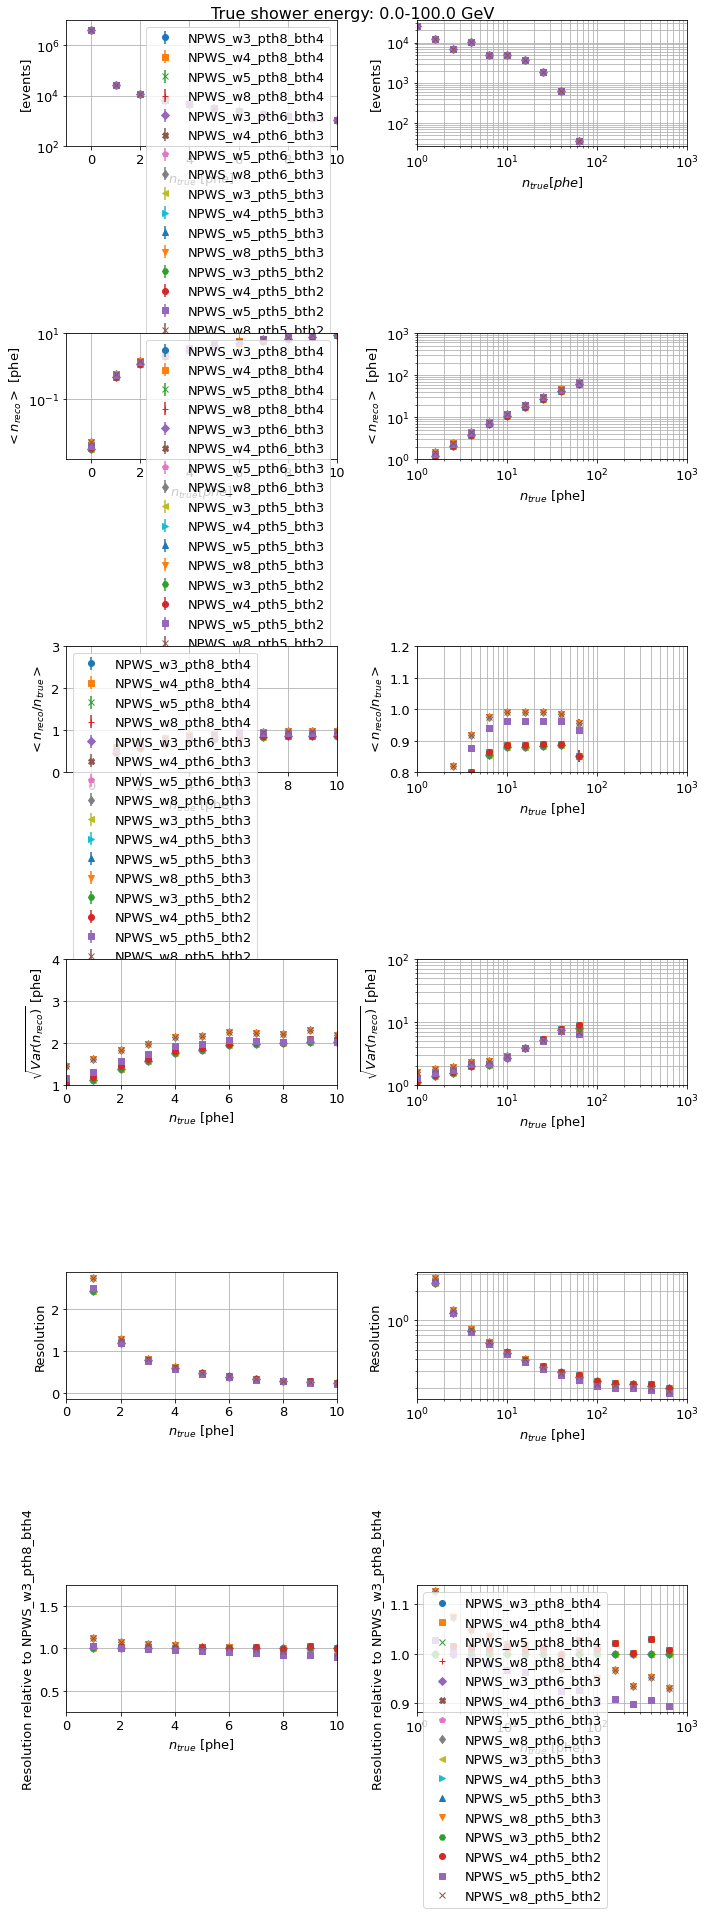

In [36]:
lowlevel_config_benchmark = lowlevel_configs[0]
dl1_data_benchmark = dl1_data_dict[lowlevel_config_benchmark]

fig, axes = plt.subplots(6, 2, figsize=(10, 25))
fig.suptitle('True shower energy: {0:.1f}-{1:.1f} GeV'.format(EMIN.to(u.GeV).value, EMAX.to(u.GeV).value), fontsize=16)
for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]
    iax = 0
    
    # Linear X-axis
    xvalues = (dl1_data.reco_phe_stats['mean'][1][:-1])
    
    # Log X-axis    
    logxvalues = (dl1_data.reco_phe_stats_log['mean'][1][:-1])
        
    # Event count 
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='major', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(100, 1e7)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('[events]')
    #axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][1].set_ylabel('[events]')
                         
    iax += 1
        
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['mean'][0], \
                          yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(-1, 10)
    axes[iax][0].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][0].set_ylabel(r'$<n_{reco}>$ [phe]')
    axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}>$ [phe]')
                         
    iax += 1

    axes[iax][0].errorbar(xvalues[1:], \
                          dl1_data.reco_phe_frac_stats['mean'][0][1:], \
                          yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(0, 3)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$<n_{reco}/n_{true}>$')

    # Log X-axis    
    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_frac_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(0.8, 1.2)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}/n_{true}>$')
                         
    iax += 1
    
    axes[iax][0].plot(xvalues, \
                    dl1_data.reco_phe_stats['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(1, 4)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')

    axes[iax][1].plot(logxvalues, \
                    dl1_data.reco_phe_stats_log['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 100)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')   
                         
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution') #(r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')

    axes[iax][1].plot(logxvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution')#r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')
    
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(0.25, 1.75)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))    

    axes[iax][1].plot(logxvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    #axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))
    
axes[0][0].legend(loc=0)   
axes[2][0].legend(loc=0)
axes[5][1].legend(loc=0)
plt.tight_layout()    

## Distribution for specific-phe-number events

In [37]:
list_true_phes = [0, 3, 6, 10] #List of the true photoelectron numbers to draw the distribution of the reconstructed phe
mask_truephe = {}
true_phe_bins = np.linspace(-10, 30, 81)

for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]    
    for tphe in list_true_phes:
        mask_truephe[tphe] = np.array(dl1_data.true_phe!=tphe)
        dl1_data.reco_phe_hists[tphe] = np.histogram(dl1_data.dl1_reco_phe, \
                                                     weights=[float(1-m) for m in mask_truephe[tphe]], \
                                                     bins=true_phe_bins)

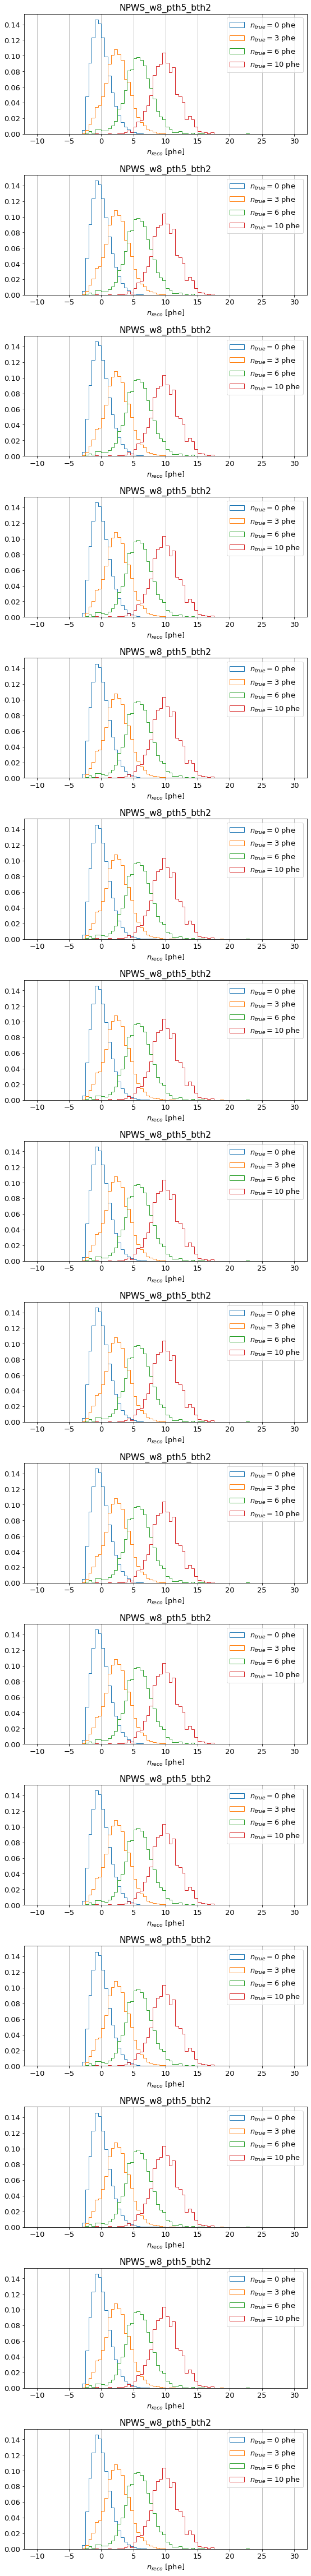

In [38]:
fig, axes = plt.subplots(len(lowlevel_configs), 1, figsize=(8, 4*len(lowlevel_configs)))
for i, image_extracter_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]     
    for j, tphe in enumerate(list_true_phes):
        axes[i].hist(dl1_data.reco_phe_hists[tphe][1][:-1], \
                     dl1_data.reco_phe_hists[tphe][1], \
                     weights=dl1_data.reco_phe_hists[tphe][0]/sum(dl1_data.reco_phe_hists[tphe][0]), \
                     label=r'$n_{{true}}={{{0}}}$ phe'.format(tphe), histtype='step')#, alpha=0.2)
    axes[i].set_title(lowlevel_config.abbreviation)
    axes[i].grid(True, which='major', axis='x')
    axes[i].set_xlabel(r'$n_{reco}$ [phe]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

## ROC Curve

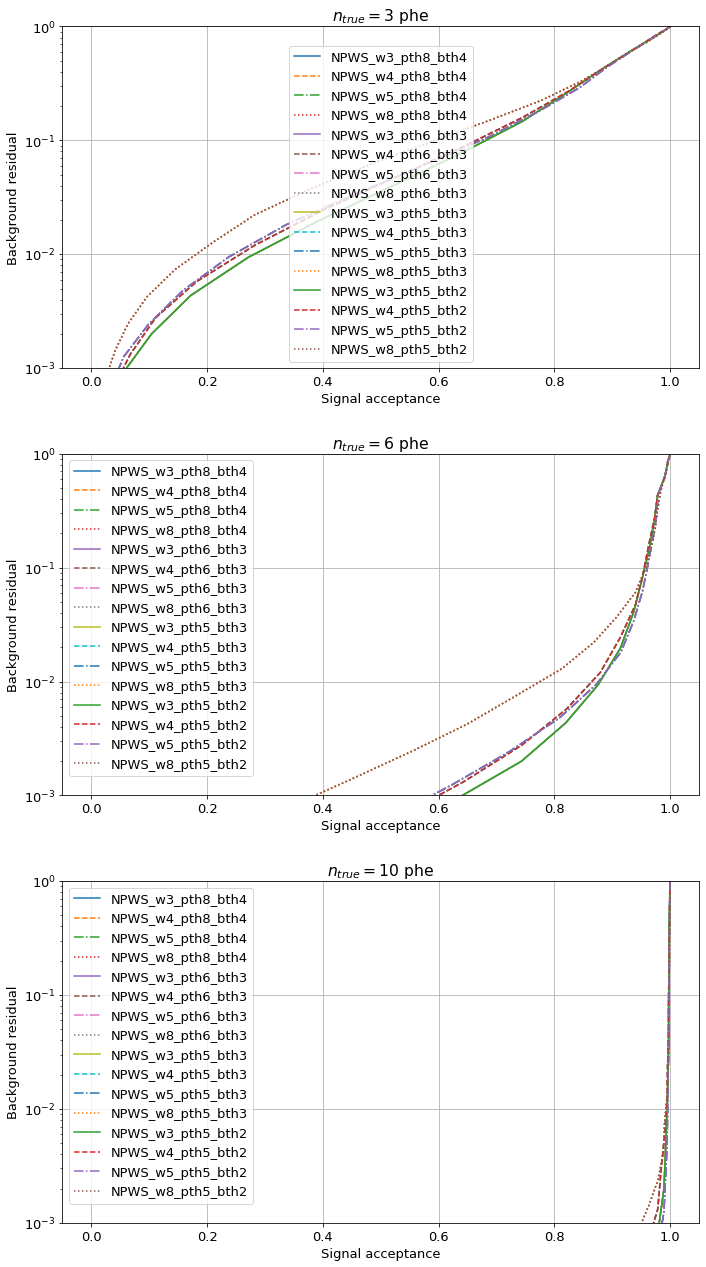

In [39]:

sig_phes = [3, 6, 10]
fig, axes = plt.subplots(len(sig_phes), 1, figsize=(10, 6*len(sig_phes)))

for i, sig_phe in enumerate(sig_phes):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        xvals, yvals = dl1_data.get_roc_curve(sig_phe=sig_phe)
        axes[i].plot(xvals, yvals, label=lowlevel_config.abbreviation, ls=LINE_STYLES[j%len(LINE_STYLES)])
    axes[i].set_title(r'$n_{{true}}={0}$ phe'.format(sig_phe))
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel('Signal acceptance')
    axes[i].set_ylabel('Background residual')
    axes[i].legend(loc=0)    
plt.tight_layout()  


# Separation power evaluation
Not working well yet

In [40]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,3])

In [41]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,6])

In [42]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,10])

# Hillas Parameters

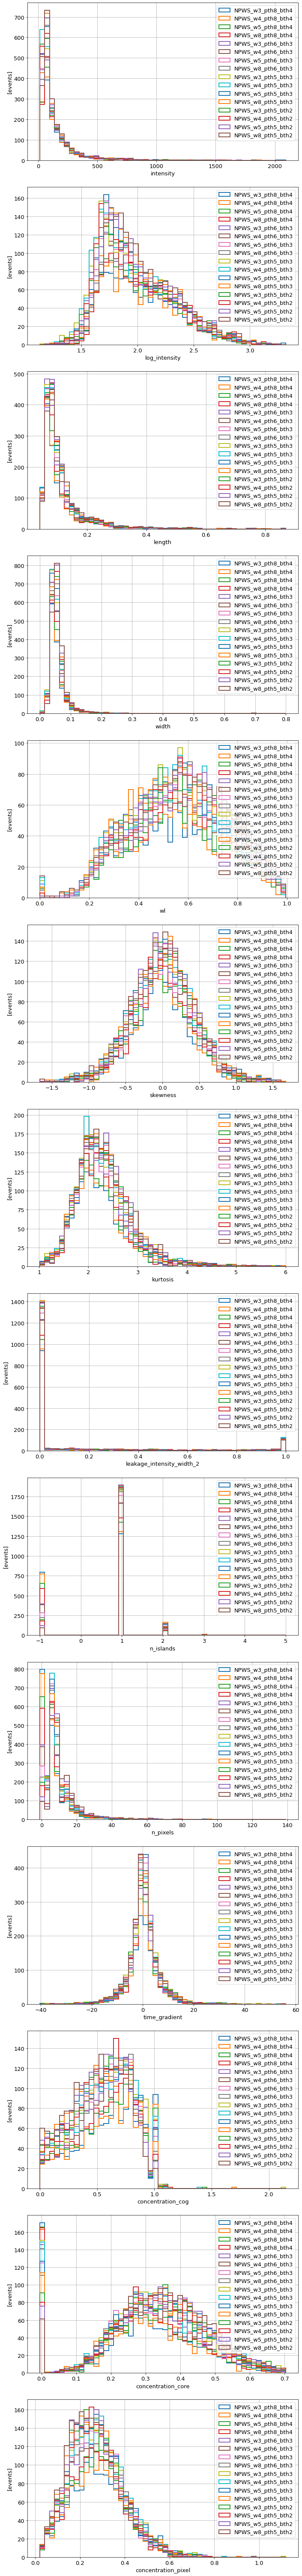

In [43]:
fig, axes = plt.subplots(len(HILLASES_OF_INTEREST), 1, figsize=(10, 6*len(HILLASES_OF_INTEREST)))

for i, param in enumerate(HILLASES_OF_INTEREST):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        vals = dl1_data.parameter_value_dict[param]
        if j==0:
            hist_result = axes[i].hist(vals, lw=2, bins=50, histtype="step", label=lowlevel_config.abbreviation)
        else:
            axes[i].hist(vals, lw=2, bins=hist_result[1], histtype="step", label=lowlevel_config.abbreviation)
    #axes[i].set_title(param)
    axes[i].grid(True, which='major', axis='both')
    #axes[i].set_yscale('log')
    #axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('[events]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

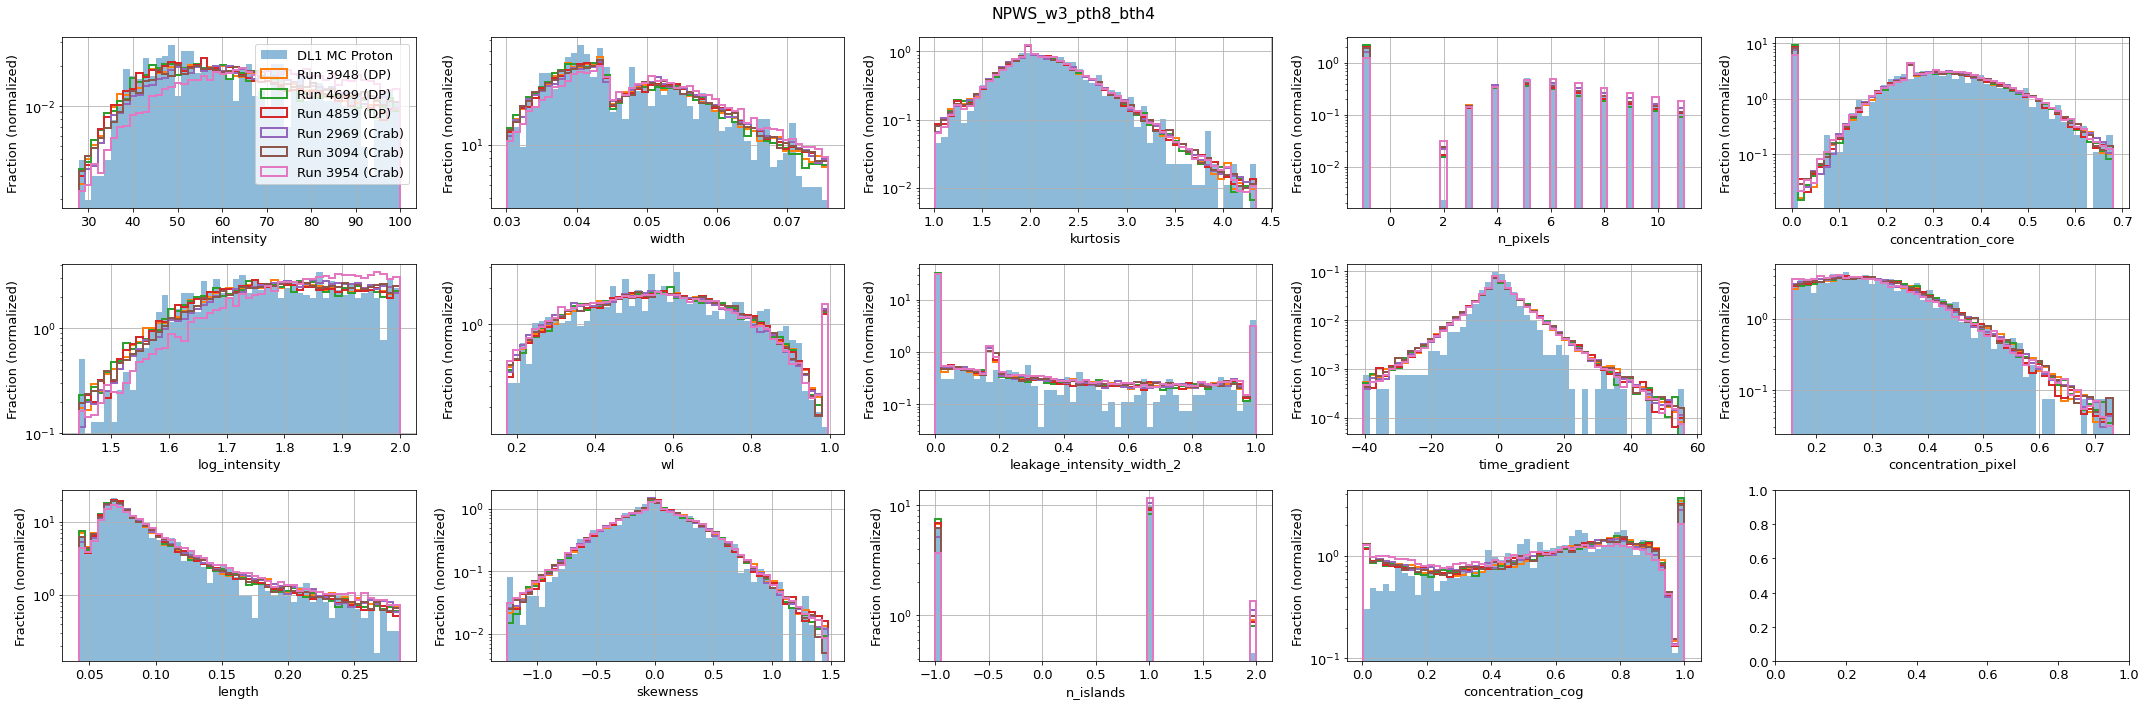

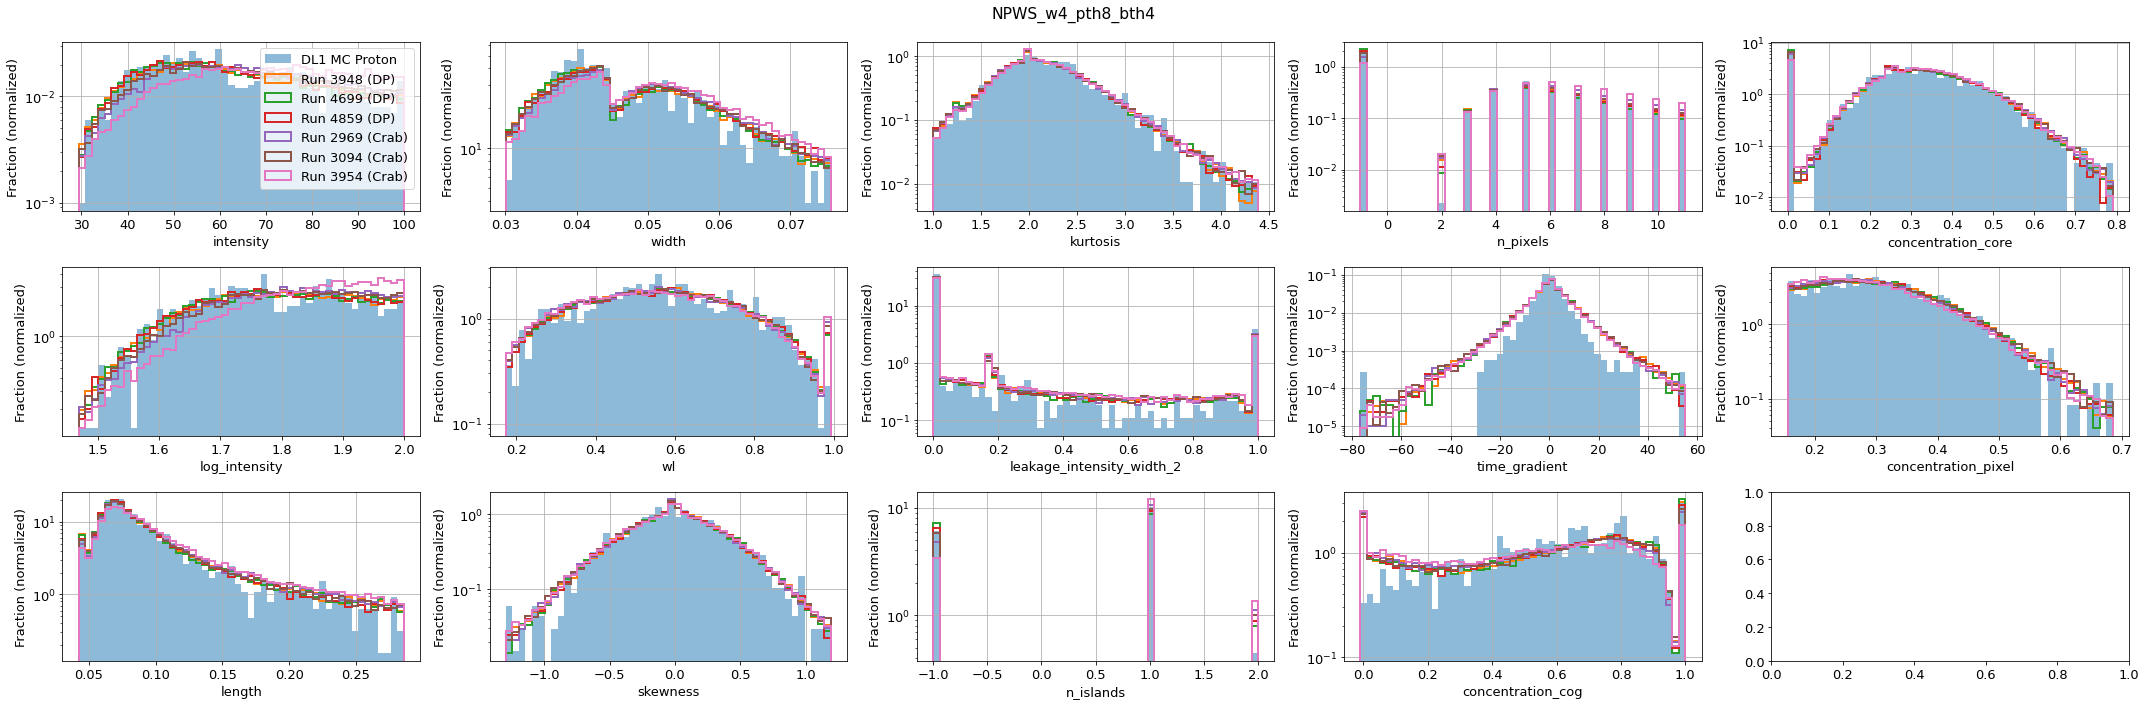

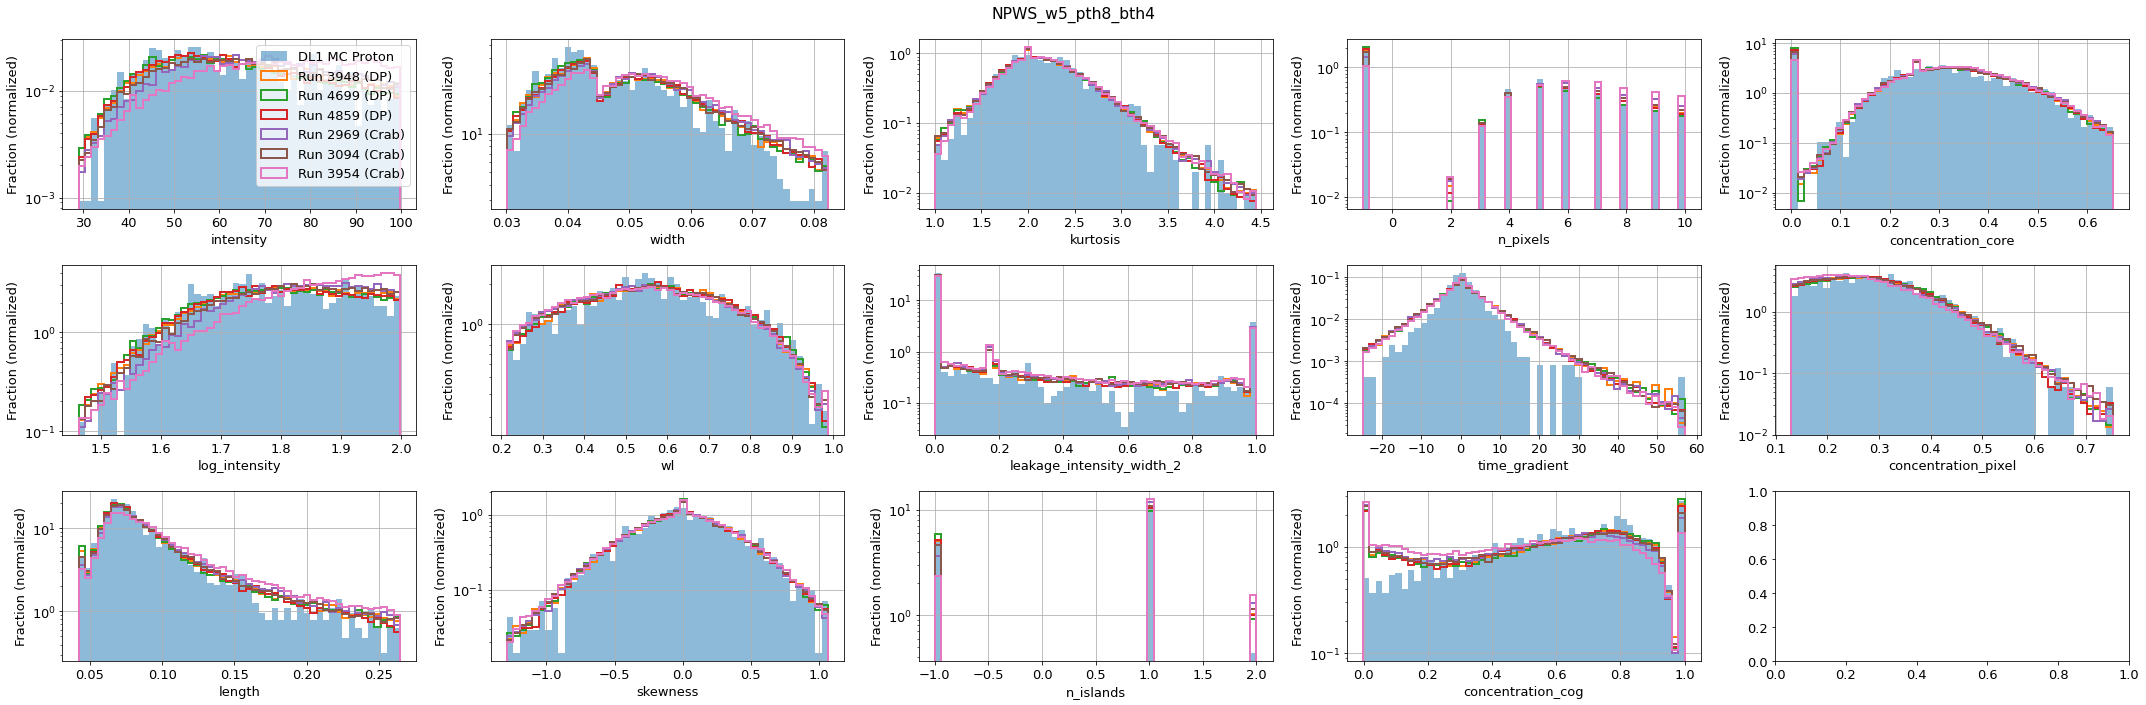

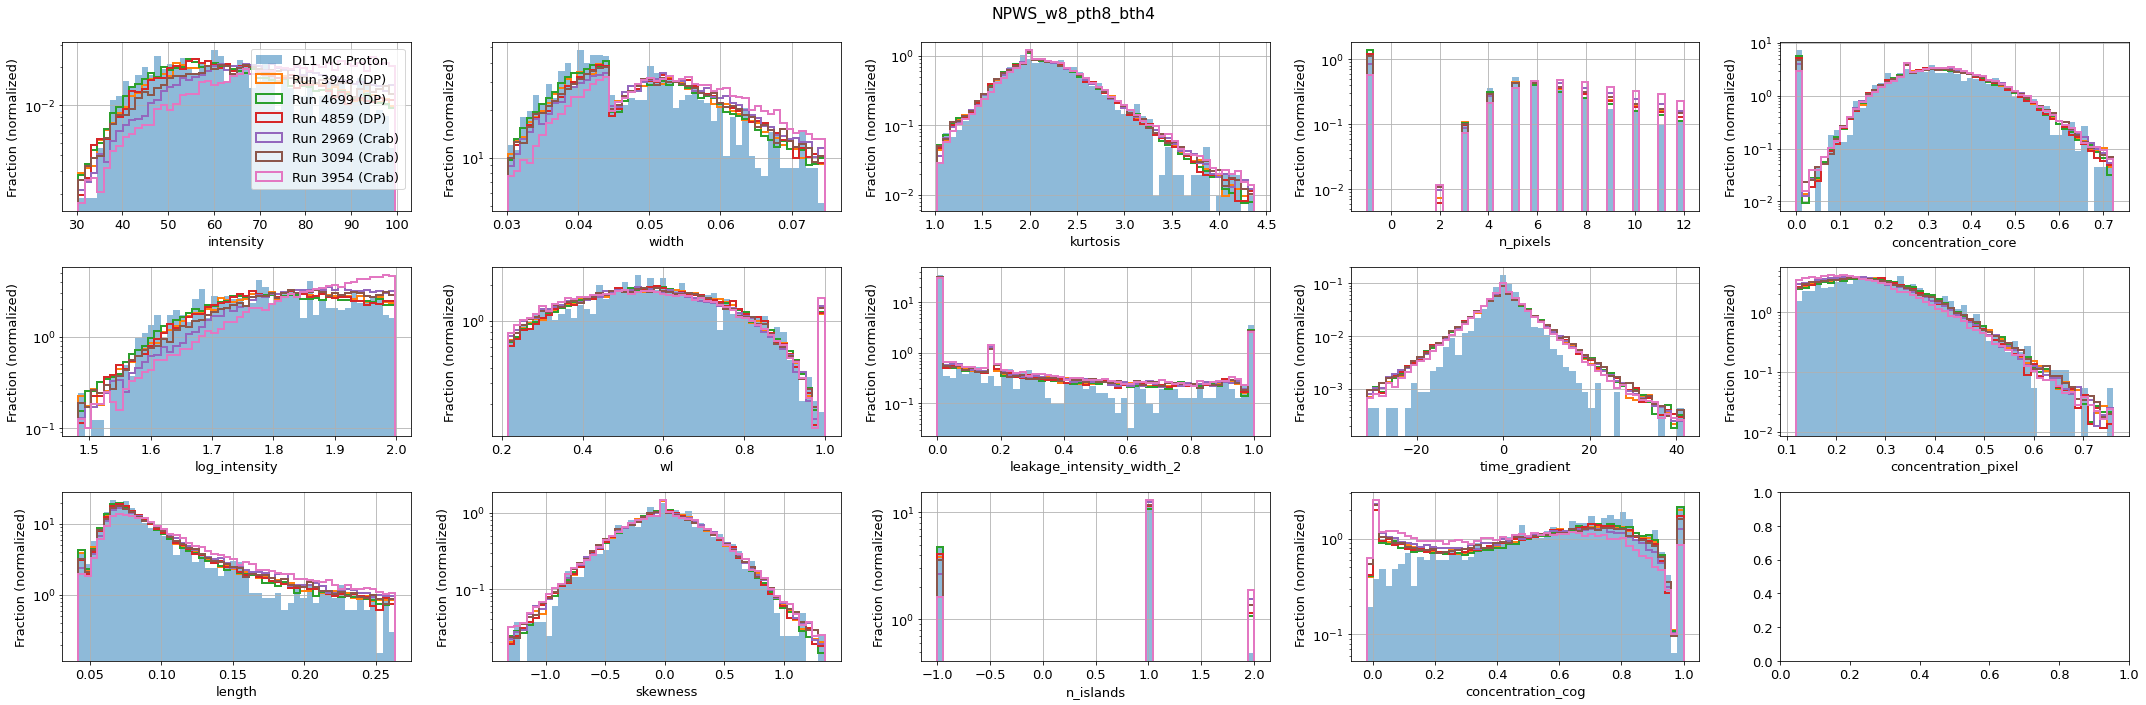

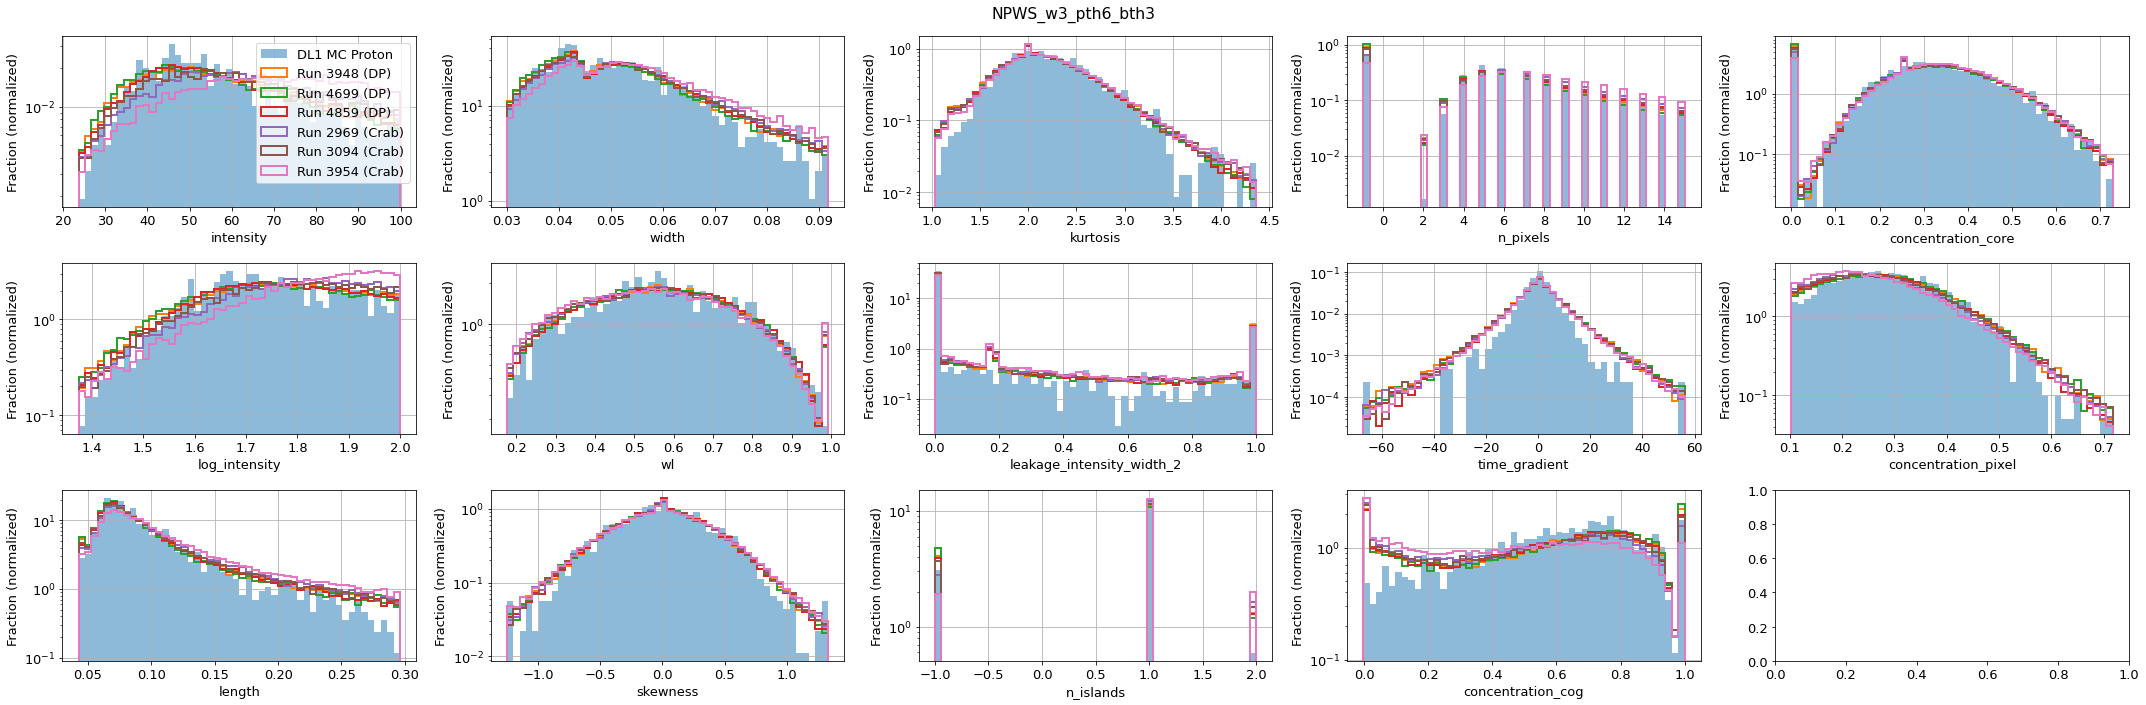

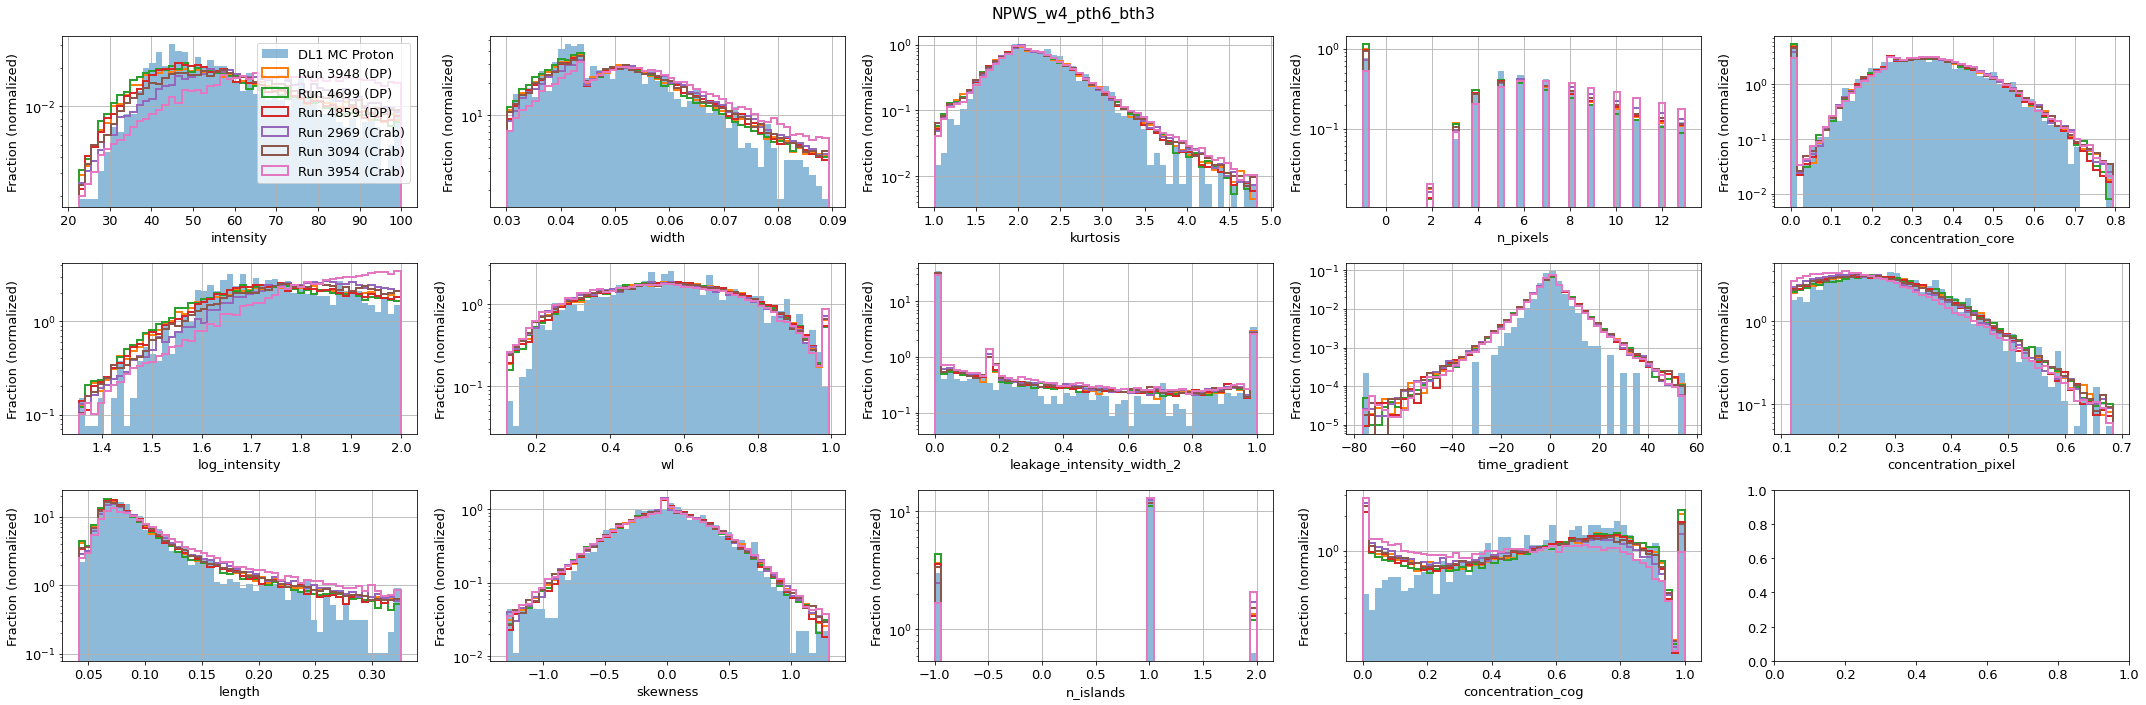

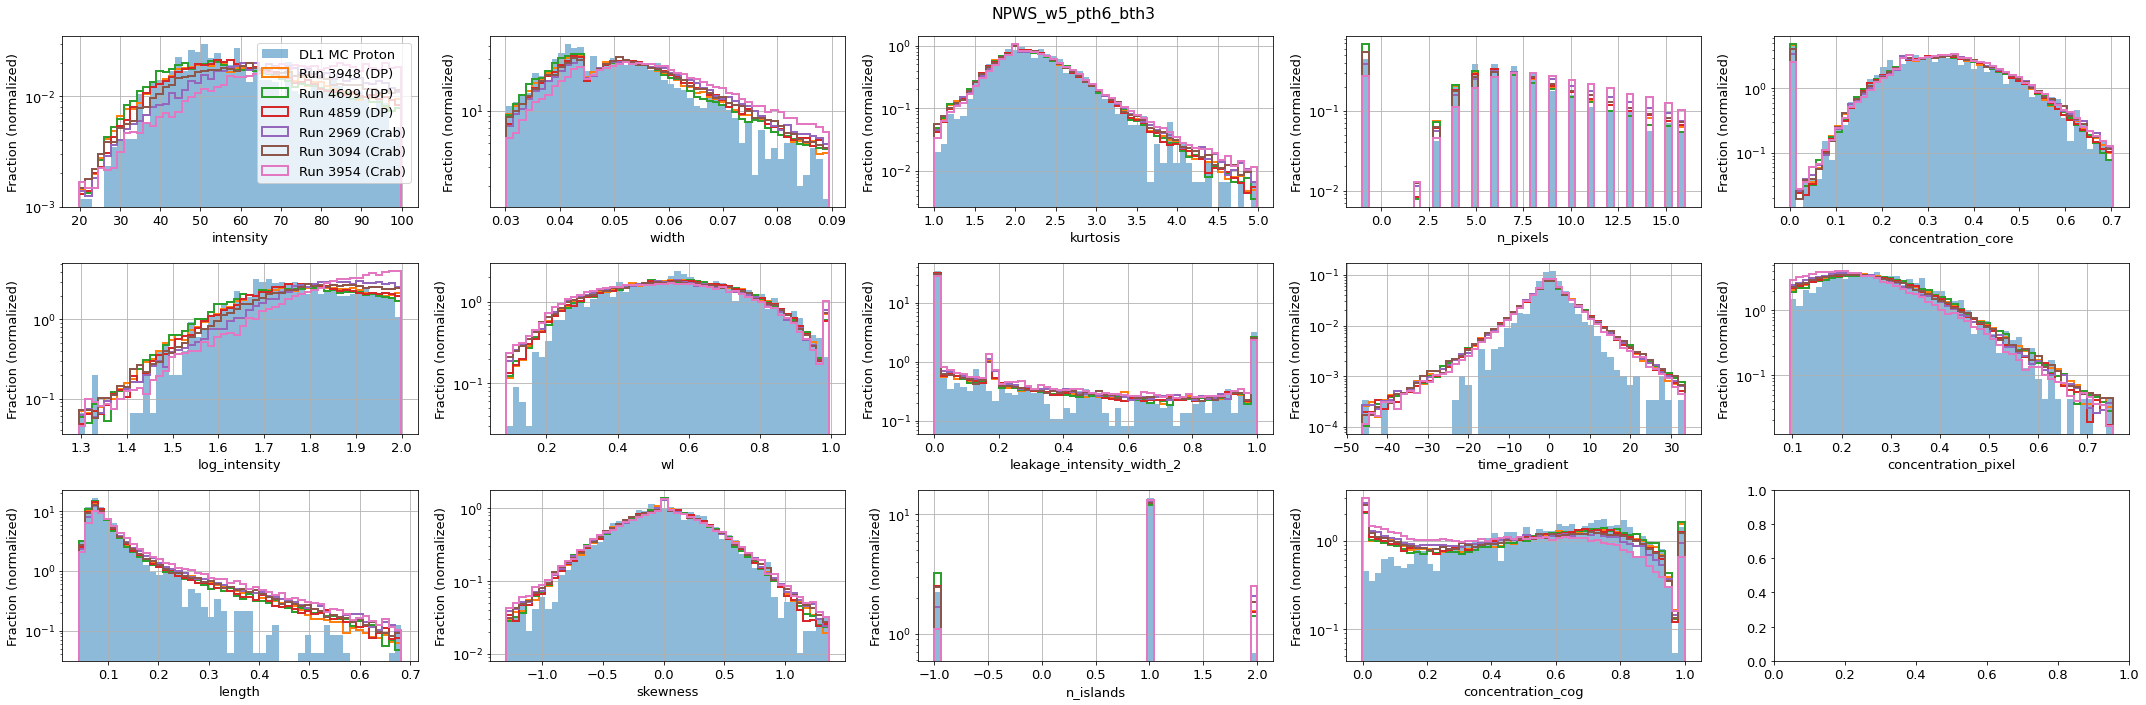

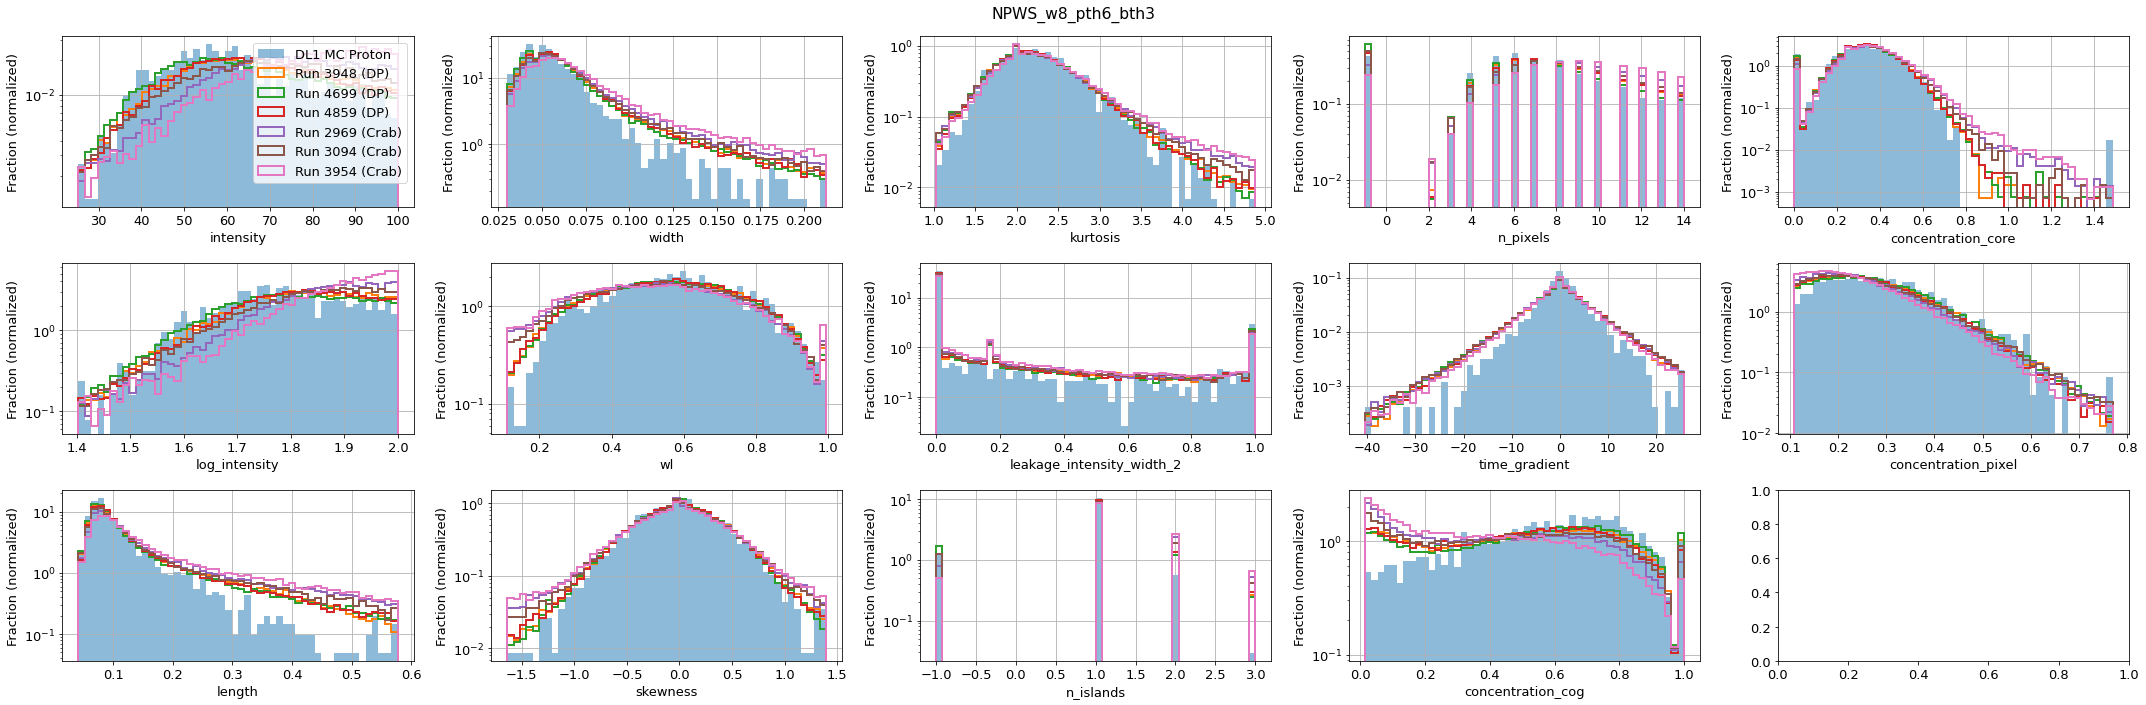

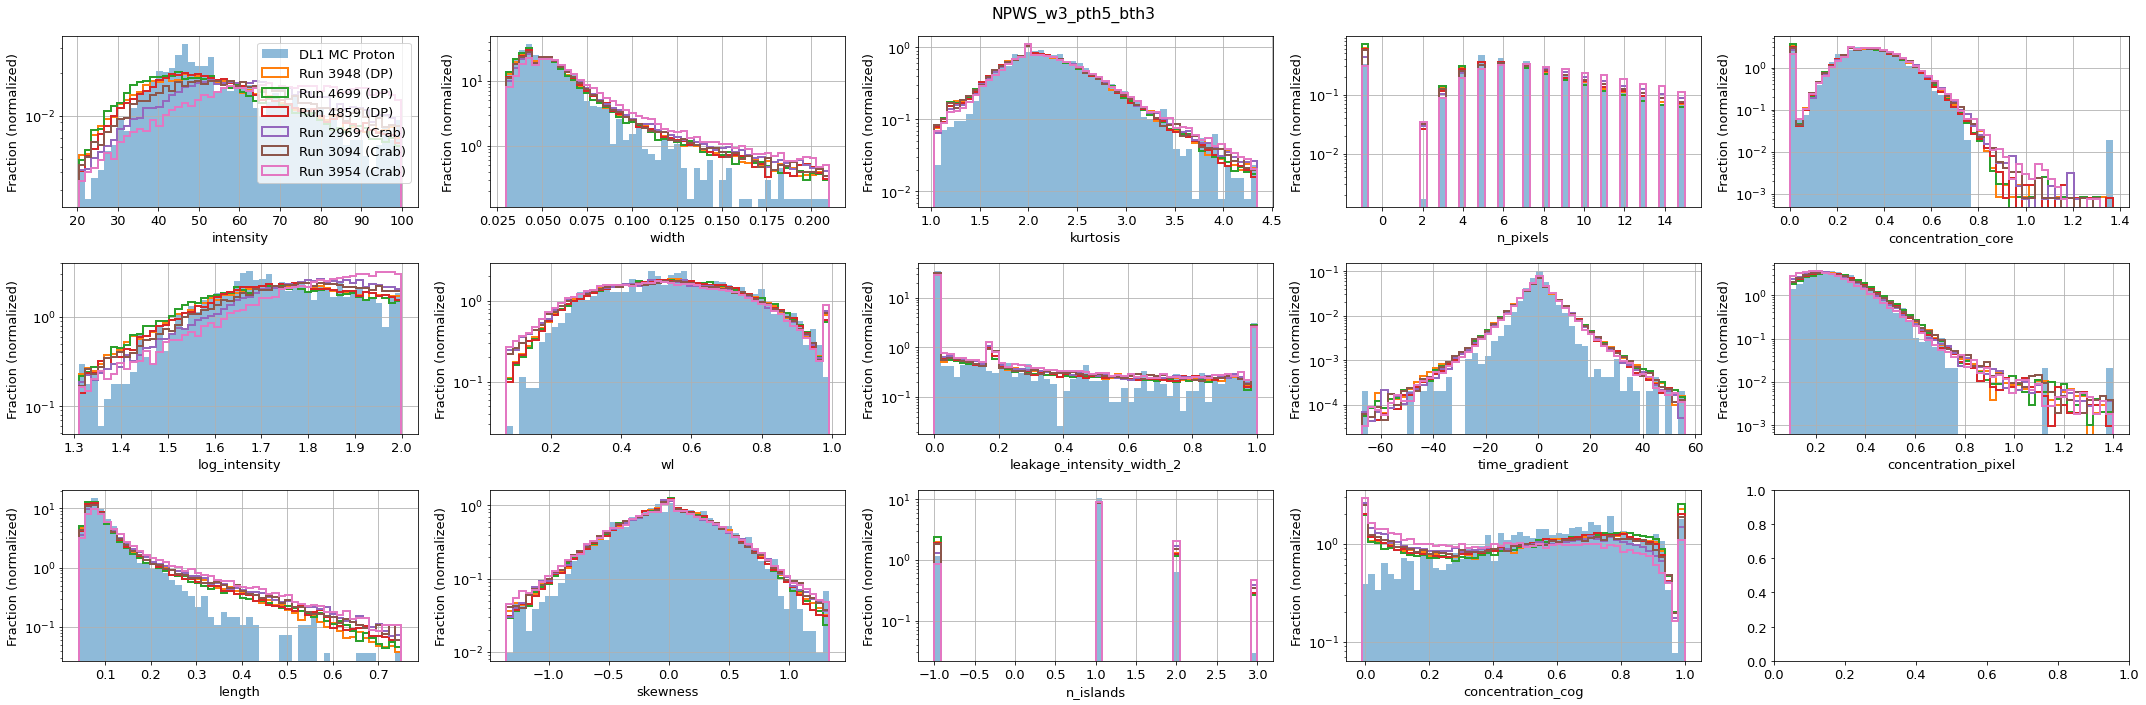

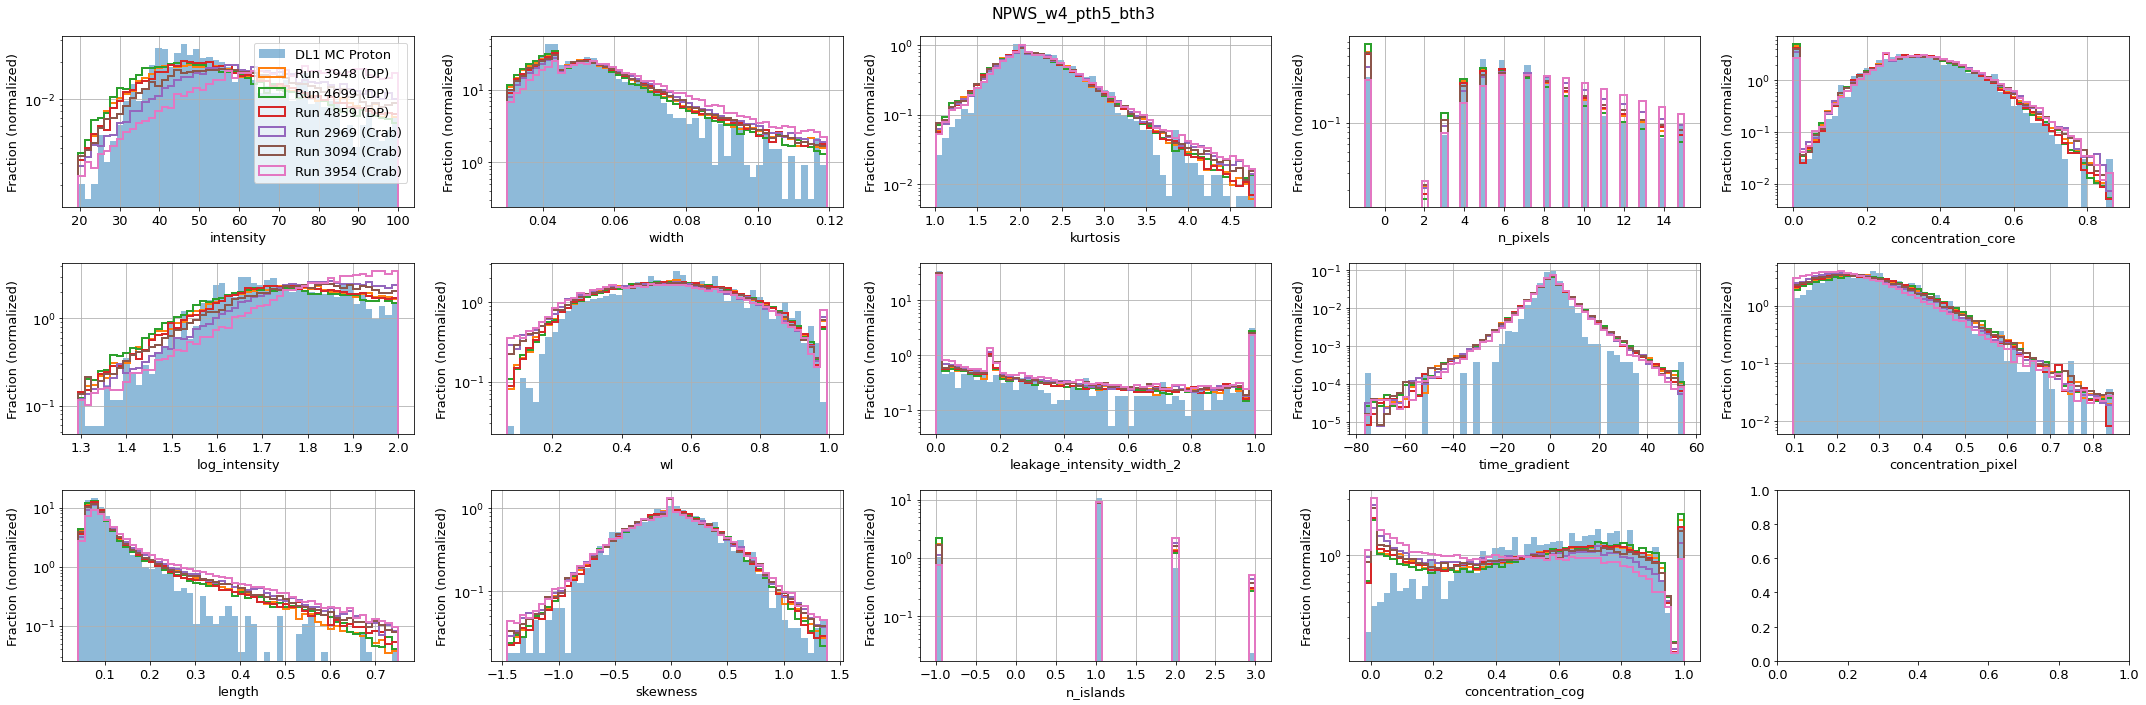

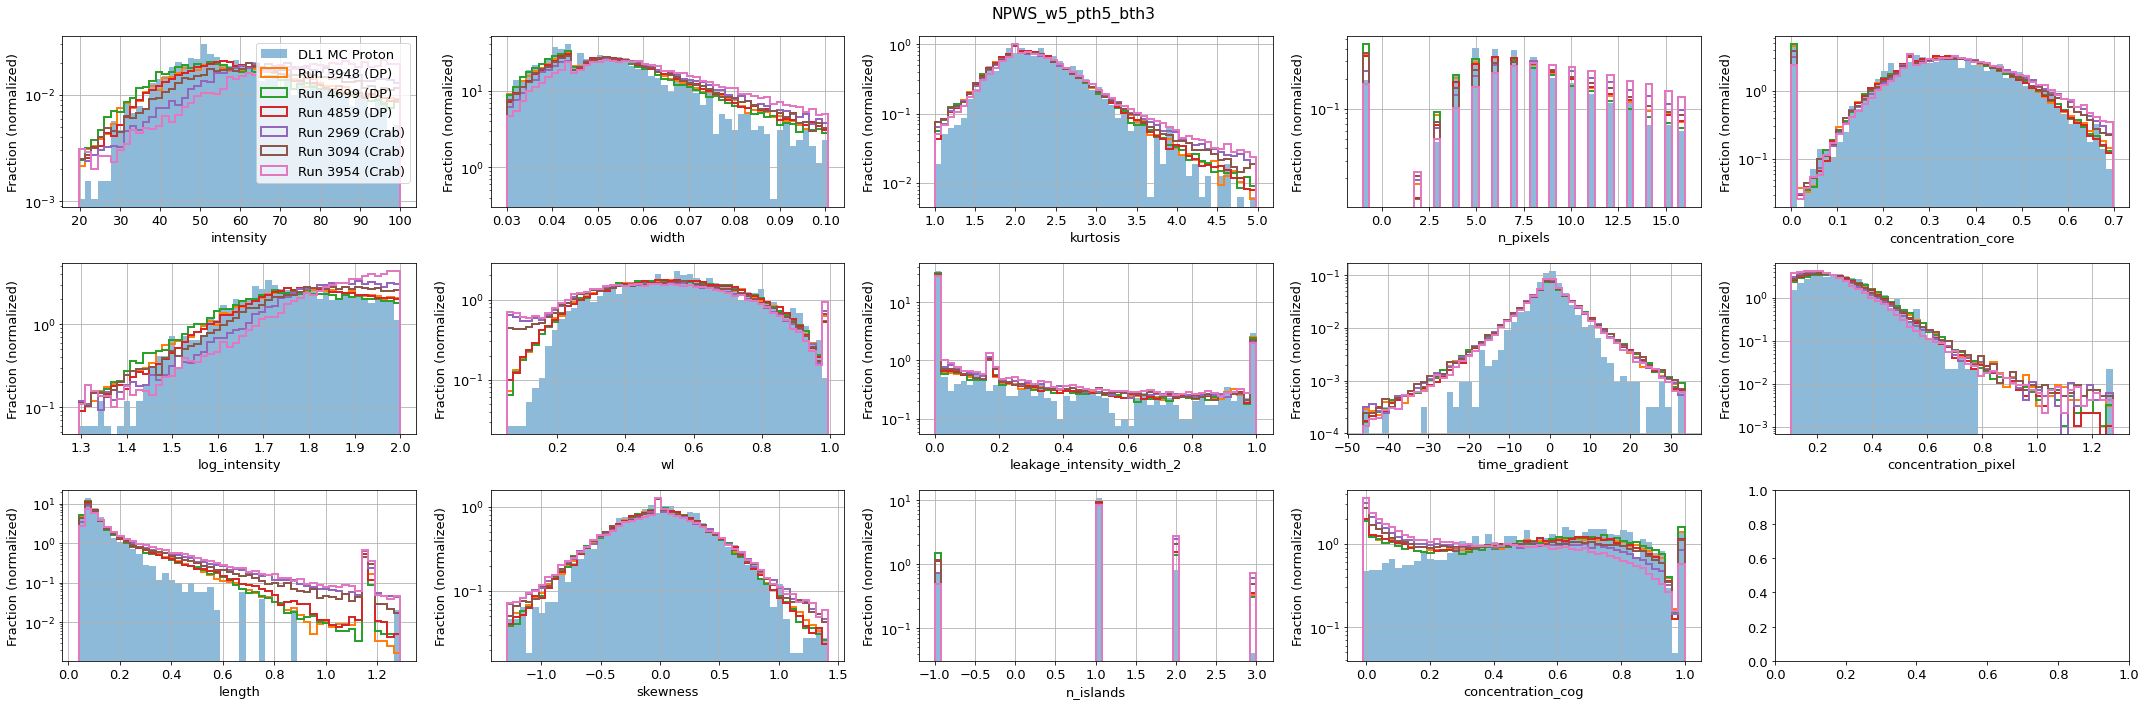

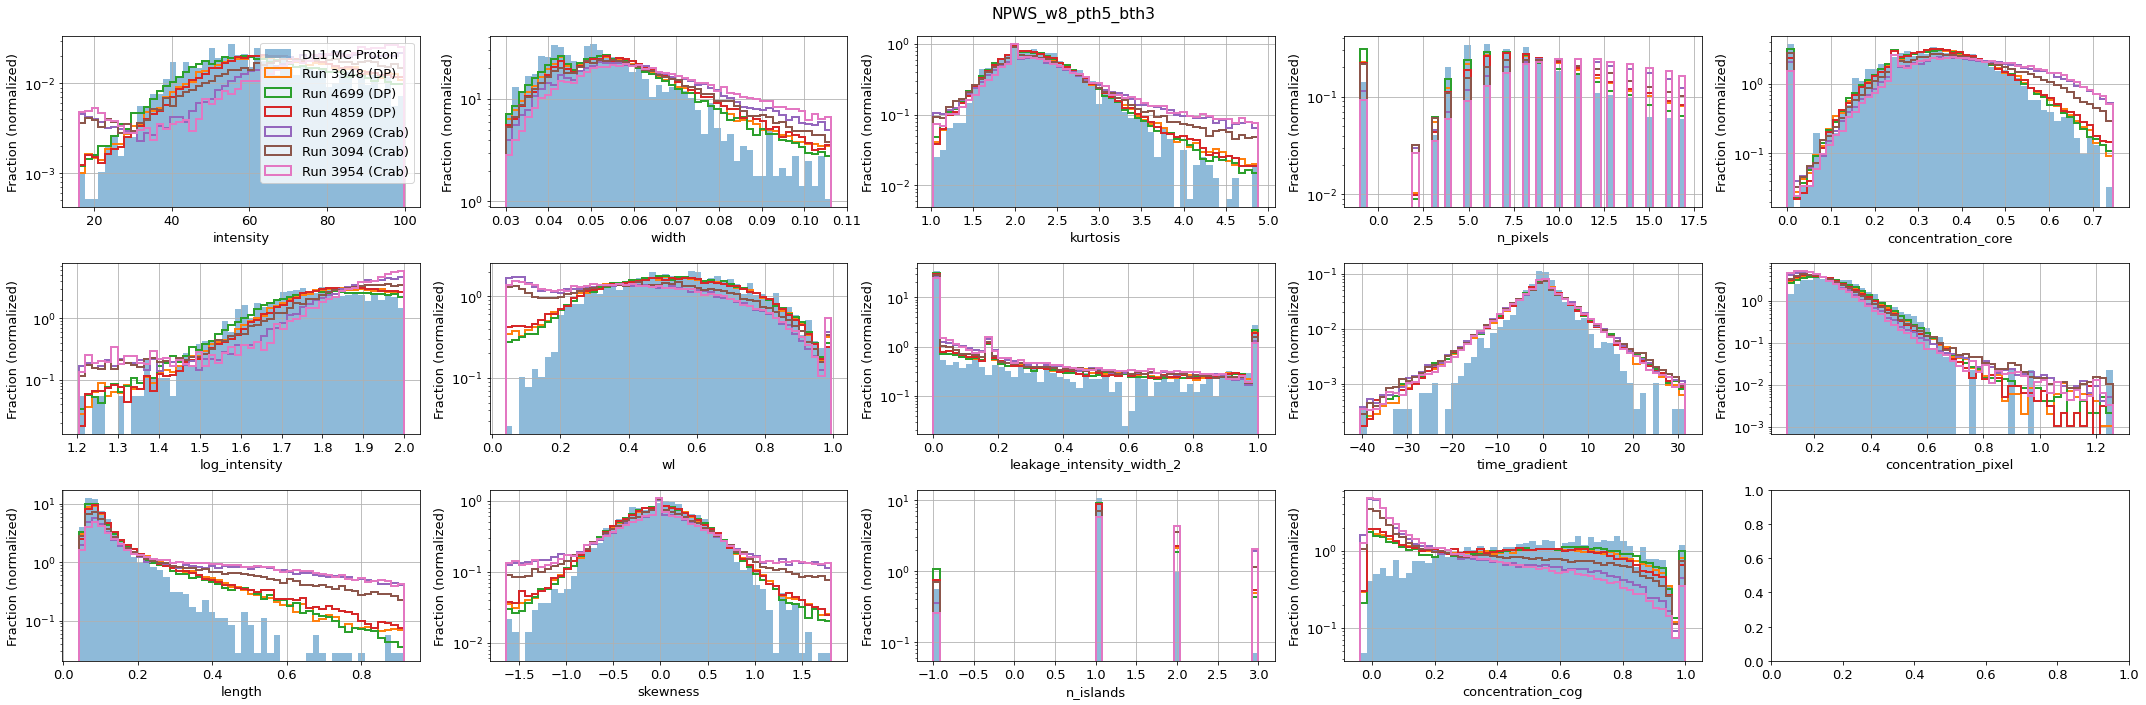

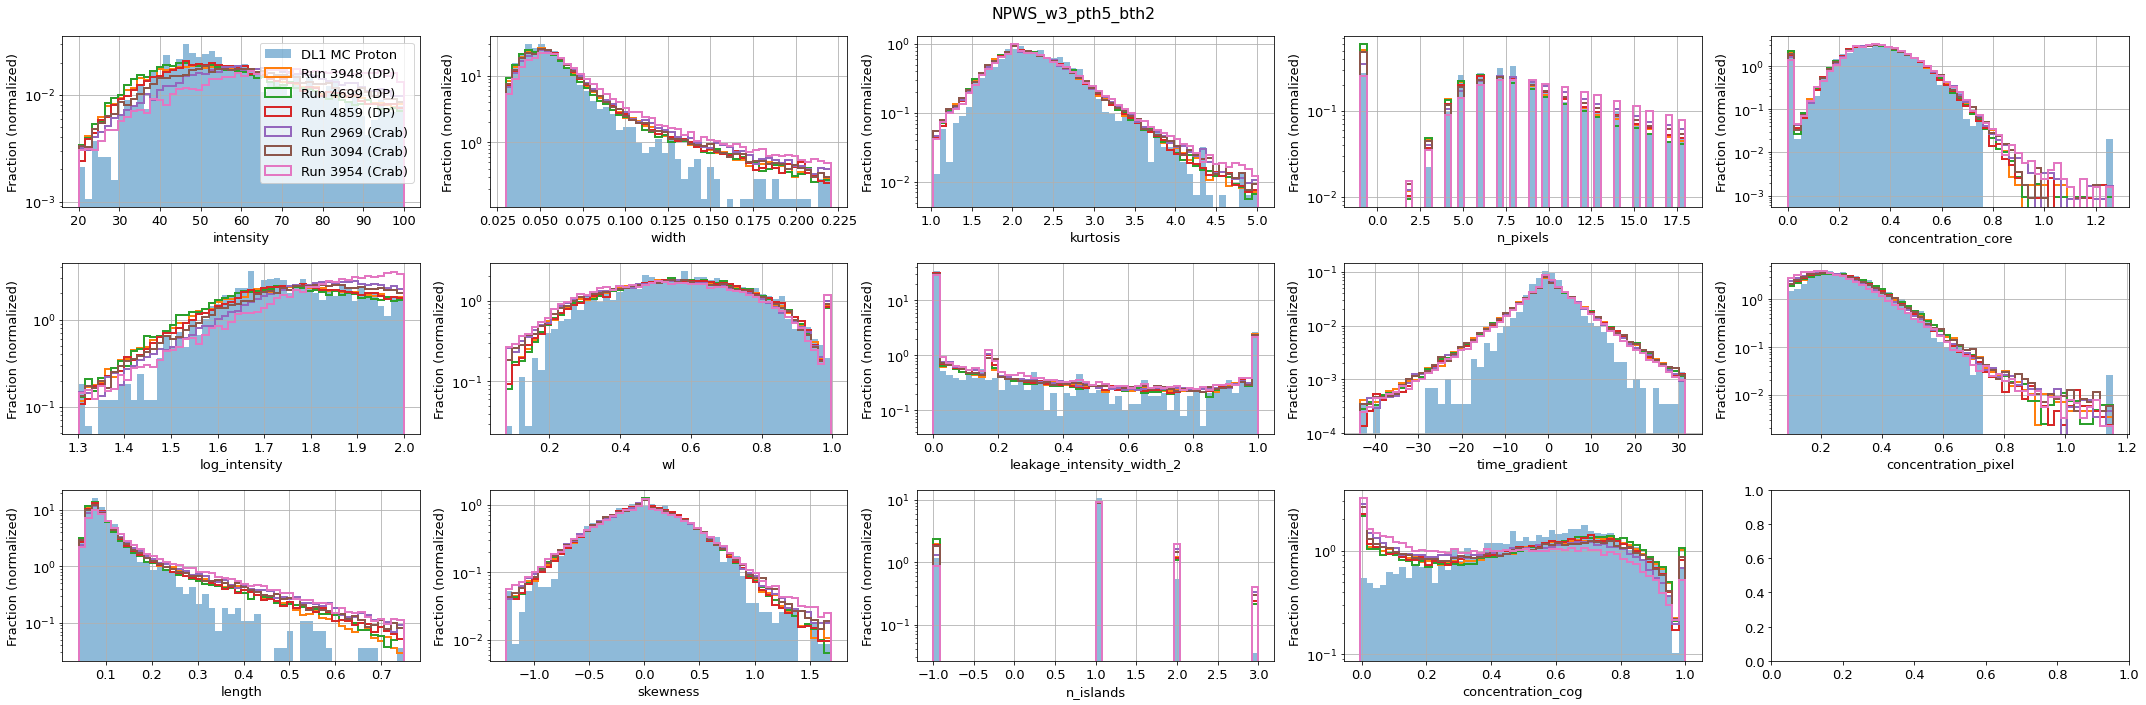

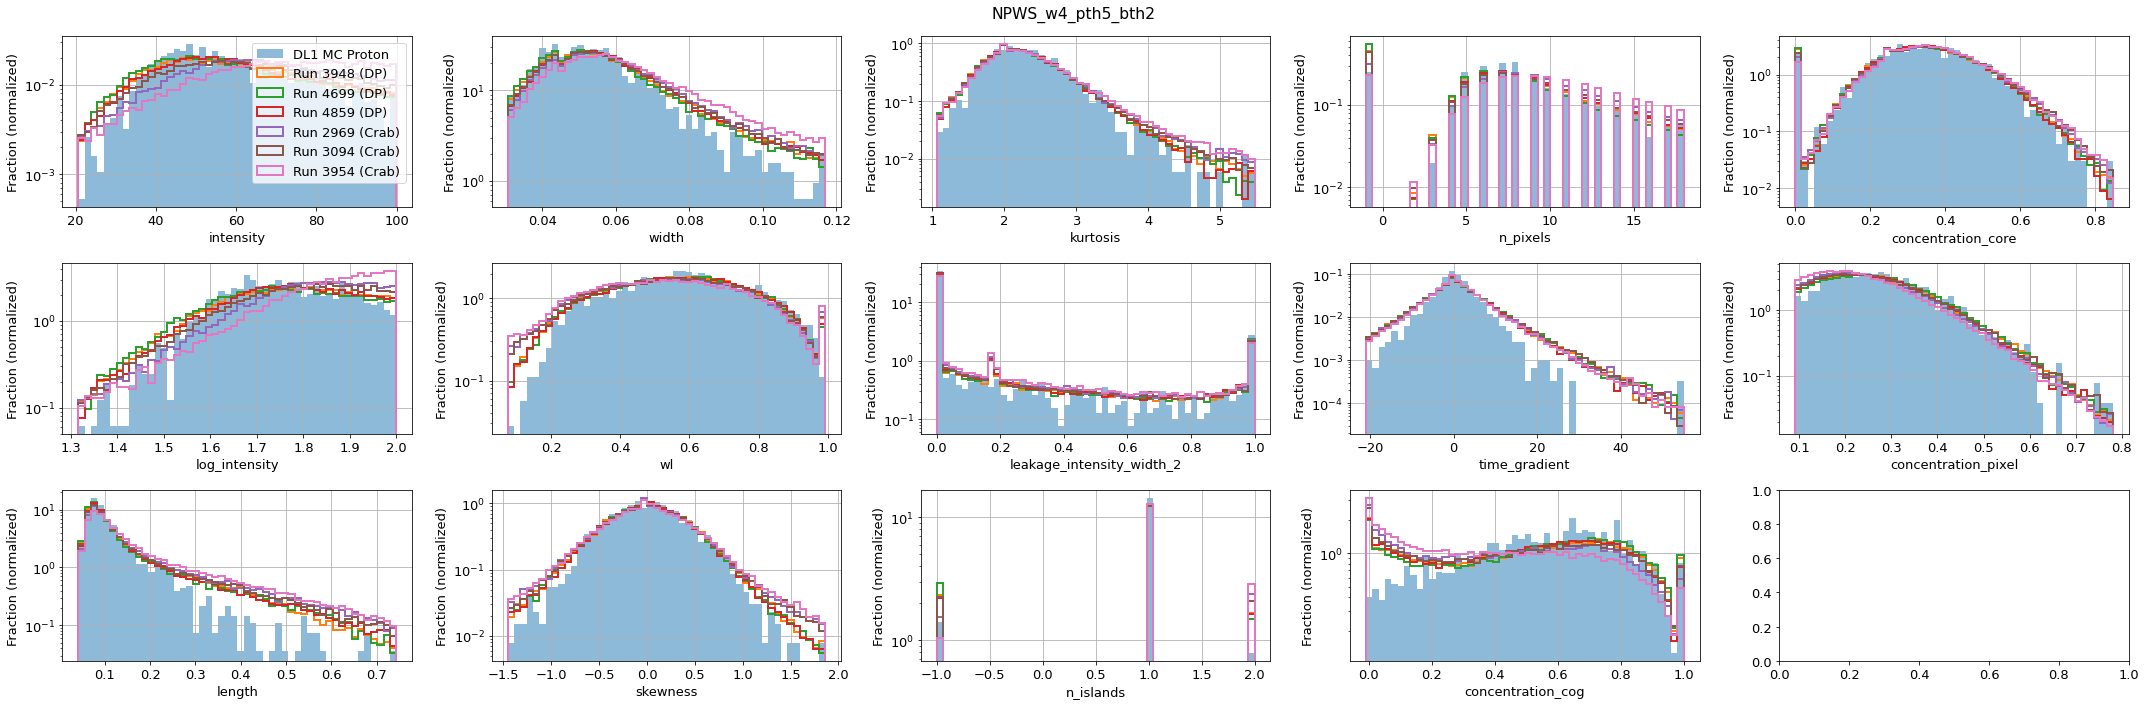

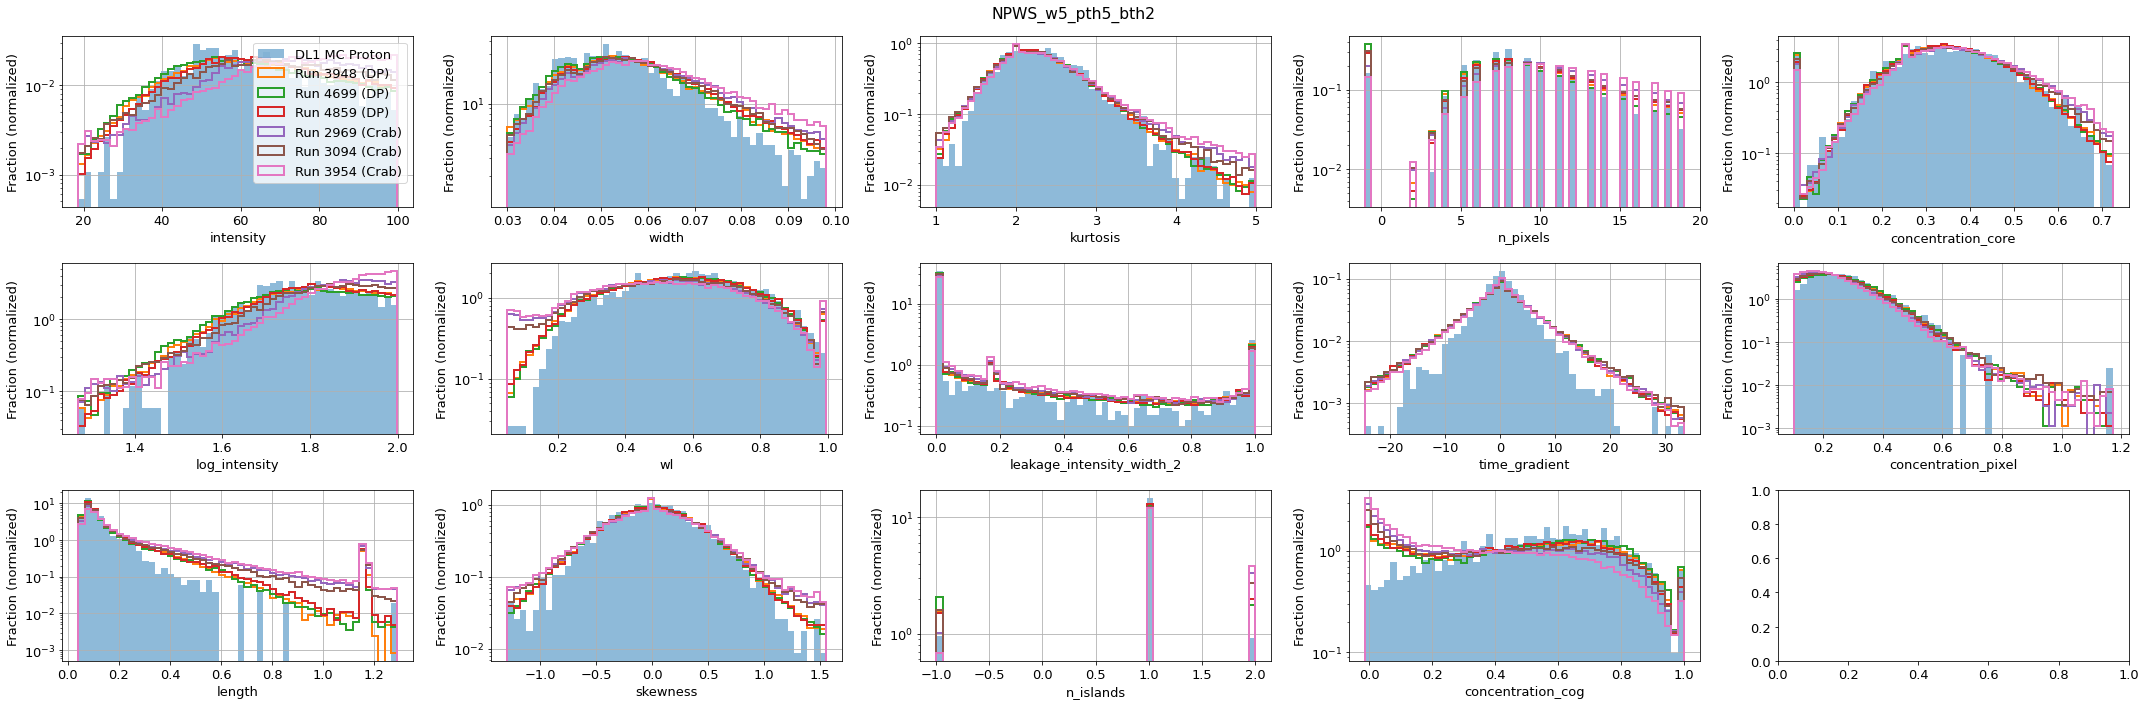

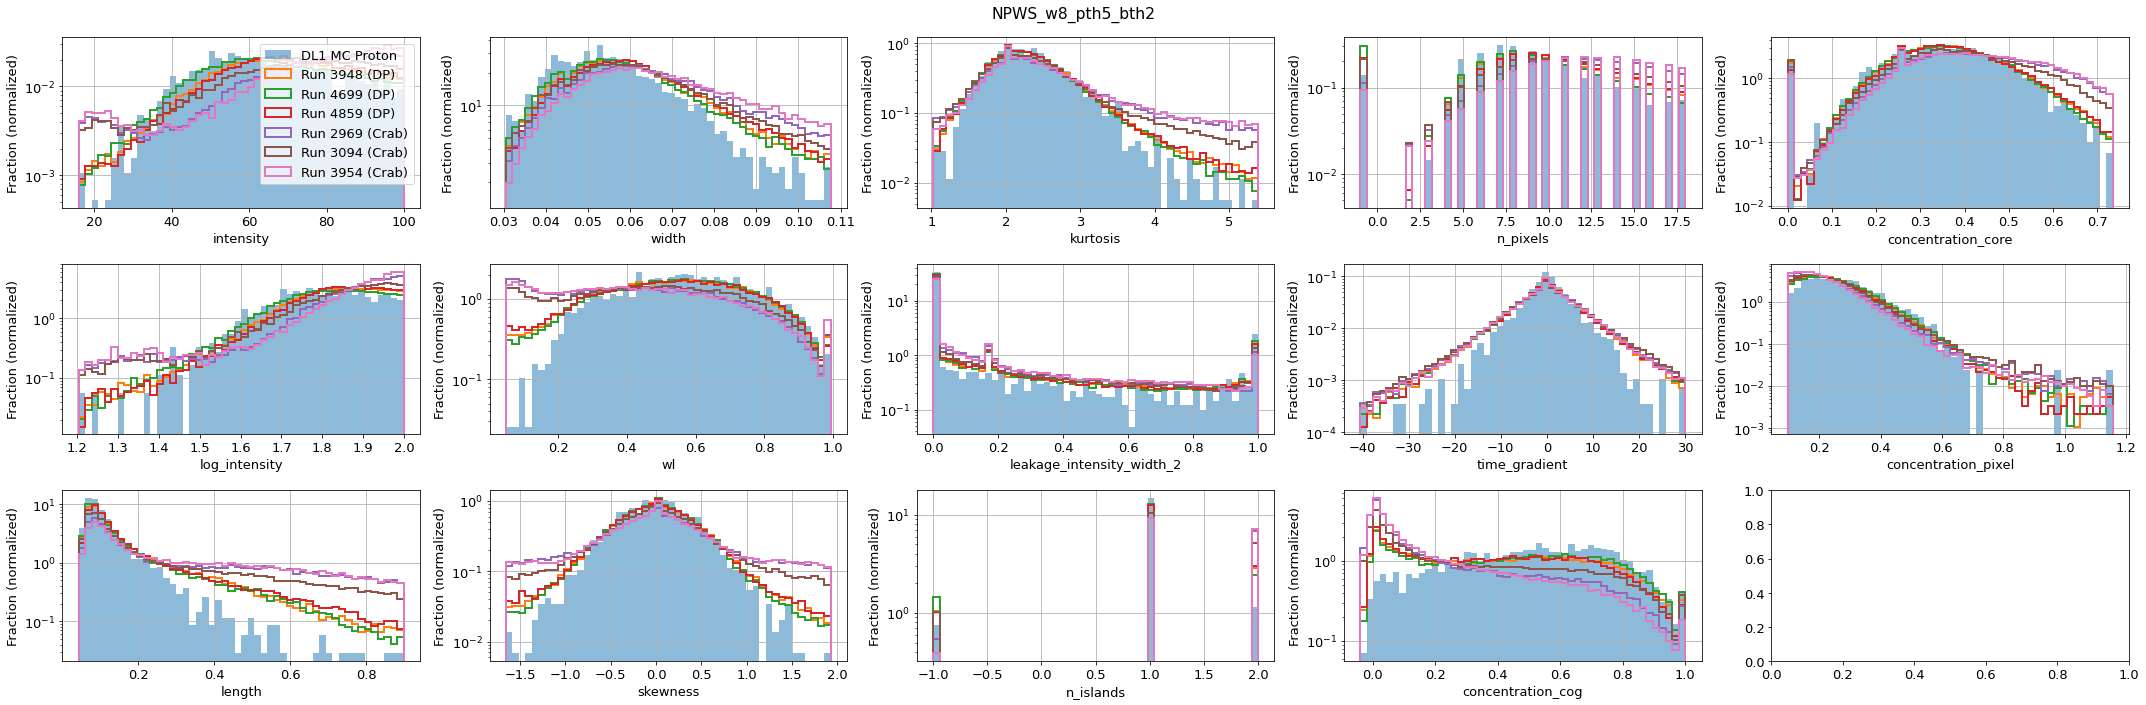

In [44]:
# Intensity cut
INTENSITY_MAX = 100 #100000
INTENSITY_MIN = 0
# Width cut
WIDTH_MIN = 0.03

plots = []
NCOLS = 3
NROWS = ceil(len(HILLASES_OF_INTEREST)/NCOLS)
for j, (lowlevel_config, real_lowlevel_config) in enumerate(zip(lowlevel_configs, real_lowlevel_configs)):
#for j, lowlevel_config in enumerate(lowlevel_configs):
    #plot.append(plt.subplots(len(lowlevel_configs), len(HILLASES_OF_INTEREST), figsize=(10,6**len(HILLASES_OF_INTEREST))))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    plots.append(plt.subplots(NCOLS, NROWS, figsize=(6*NROWS, 10)))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    fig, axes = plots[-1]
    fig.suptitle(lowlevel_config.abbreviation)
    dl1_mc = dl1_data_dict[lowlevel_config] 
    
    #mask_trigger_mc = (np.array(dl1_mc.parameter_value_dict["intensity"])<INTENSITY_MIN) \
    #                + (np.array(dl1_mc.parameter_value_dict["intensity"])>INTENSITY_MAX)

    # Mask MC events
    mcevent_masks = {}
    mcevent_masks["intensity>{imax}".format(imax=INTENSITY_MAX)] = np.array(dl1_mc.parameter_value_dict["intensity"])>INTENSITY_MAX
    mcevent_masks["intensity<={imin}".format(imin=INTENSITY_MIN)] = np.array(dl1_mc.parameter_value_dict["intensity"])<=INTENSITY_MIN
    mcevent_masks["width<={wmin}".format(wmin=WIDTH_MIN)] = np.array(dl1_mc.parameter_value_dict["width"])<=WIDTH_MIN            
    mcmask_sum = np.zeros_like(dl1_mc.parameter_value_dict["intensity"])
    for mask_array in mcevent_masks.values():
        mcmask_sum += mask_array
        
    # Mask real events
    dl1_data = {}
    mask_sum = {}
    for run in real_runs:
        dl1_data[run] = real_dl1_data_dict[real_lowlevel_config][run]         
        event_masks = {}
        for mask_key in [EventType.FLATFIELD, EventType.SKY_PEDESTAL]:
            event_masks[mask_key] = np.array(dl1_data[run].parameter_value_dict["event_type"])==mask_key.value
        event_masks["intensity>{imax}".format(imax=INTENSITY_MAX)] = np.array(dl1_data[run].parameter_value_dict["intensity"])>INTENSITY_MAX
        event_masks["intensity<={imin}".format(imin=INTENSITY_MIN)] = np.array(dl1_data[run].parameter_value_dict["intensity"])<=INTENSITY_MIN
        event_masks["width<={wmin}".format(wmin=WIDTH_MIN)] = np.array(dl1_data[run].parameter_value_dict["width"])<=WIDTH_MIN            
        mask_sum[run] = np.zeros_like(dl1_data[run].parameter_value_dict["event_type"])
        for mask_array in event_masks.values():
            mask_sum[run] += mask_array        
                
    #logger.warning('{0}/{1}'.format(sum(mask_trigger_mc), len(mask_trigger_mc)))    
    for i, param in enumerate(HILLASES_OF_INTEREST):
        # MC
        vals_mc = ma.masked_array(dl1_mc.parameter_value_dict[param], mask=mcmask_sum)
        hist_results = {}
        if not param in hist_results.keys():
            hist_results[param] = axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=50, histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        else:
            axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=hist_results[param][1], histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        # Real
        for run in real_runs:
            #dl1_data = real_dl1_data_dict[real_lowlevel_config][run]
            
            #mask_trigger = \
            #(np.array(dl1_data.parameter_value_dict["intensity"])<INTENSITY_MIN) \
            #+ (np.array(dl1_data.parameter_value_dict["intensity"])>INTENSITY_MAX) 
            # Mask events
                
            vals = ma.masked_array(dl1_data[run].parameter_value_dict[param], mask=mask_sum[run])
            axes[i%NCOLS][int(i/NCOLS)].hist(vals, lw=2, bins=hist_results[param][1], histtype="step", label='Run {run} ({src})'.format(run=run, src=source_runs[run]), density=True)
        #title = lowlevel_config.abbreviation
        #axes[int(i/NCOLS)][i%NCOLS].set_title(title)
        axes[i%NCOLS][int(i/NCOLS)].grid(True, which='major', axis='both')
        axes[i%NCOLS][int(i/NCOLS)].set_yscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_xscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_ylim(1e-3, 1)
        #if j==len(lowlevel_configs)-1:
        axes[i%NCOLS][int(i/NCOLS)].set_xlabel(param)
        axes[i%NCOLS][int(i/NCOLS)].set_ylabel('Fraction (normalized)')
        if i==0:
            axes[i%NCOLS][int(i/NCOLS)].legend(loc=0)    
    plt.tight_layout() 
    fig_path = lowlevel_config.product_dir_path / "plots" \
    / '{conf}_Intensity{imin}-{imax}.{ext}'.format(conf=lowlevel_config.name, imin=INTENSITY_MIN, imax=INTENSITY_MAX, ext=".png")
    if not fig_path.parent.is_dir():
        os.makedirs(fig_path.parent)
    fig.savefig(fig_path)